# 第7章 网络优化与正则化

神经网络具有非常强的表达能力，但当应用神经网络模型到机器学习时依然存在一些难点问题。首先，神经网络的损失函数是一个非凸函数，找到全局最优解通常比较困难。其次，深度神经网络的参数非常多，训练数据也比较大，因此也无法使用计算代价很高的二阶优化方法，而一阶优化方法的训练效率通常比较低。此外，深度神经网络存在梯度消失或爆炸问题，导致基于梯度的优化方法经常失效。

目前，神经网络变得流行除了本身模型能力强之外，还有一个重要的原因是研究者从大量的实践中总结了一些经验方法，在神经网络的表示能力、复杂度、学习效率和泛化能力之间找到了比较好的平衡。本章主要介绍神经网络的参数学习中常用的优化和正则化方法。

本章内容基于神经网络与深度学习》第7章：网络优化与正则化相关内容进行设计。在阅读本章之前，建议先了解如图7.1所示的关键知识点，以便更好地理解和掌握相应的理论和实践知识。

<center><image src="https://ai-studio-static-online.cdn.bcebos.com/95762b1e60984b56ac0d7ca32c1bff40ca0edf2de62a4cb598751257fe89e72f" width=500/></center><br></br>
<center>图7.1 网络优化和正则化关键知识点回顾</center><br></br>

本章内容主要包含两部分：
* 网络优化：通过案例和可视化对优化算法、参数初始化、逐层规范化等网络优化算法进行分析和对比，展示它们的效果，通过代码详细展示这些算法的实现过程。
* 网络正则化：通过案例和可视化对$\ell_{1}$和$\ell_{2}$正则化、权重衰减、暂退法等网络正则化方法进行分析和对比，展示它们的效果。

**提醒**

在本书中，对《神经网络与深度学习》中一些术语的翻译进行修正。Normalization翻译为规范化、Dropout翻译为暂退法。

## 7.1 小批量梯度下降法

目前，深度神经网络的优化方法主要是通过梯度下降法来寻找一组可以最小化结构风险的参数。在具体实现中，梯度下降法可以分为批量梯度下降、随机梯度下降和小批量梯度下降(Mini-Batch Gradient Descent)三种方式。它们的区别在于批大小（Batch Size）不同，这三种梯度下降法分别针对全部样本、单个随机样本和小批量随机样本进行梯度计算。根据不同的数据量和参数量，可以选择不同的实现形式。
下面我们以小批量梯度下降法为主进行介绍。


令$f(\bm x; \theta)$表示一个神经网络模型，$\theta$为模型参数，$\mathcal{L}(\cdot)$为可微分的损失函数，$\nabla_\theta \mathcal{L}(\bm y, f(\bm x; \theta))=\frac{\partial \mathcal{L}(\bm y, f(\bm x; \theta))}{\partial \theta}$为损失函数关于参数$\theta$的偏导数。在使用小批量梯度下降法进行优化时，每次选取$K$个训练样本$\mathcal{S}_t = {(\bm x^{(k)}, \bm y^{(k)})}^K_{k=1}$。第$t$次迭代时参数$\theta$的梯度为

$$
\mathbf g_t = \frac{1}{K}\sum_{(\bm x, \bm y) \in \mathcal{S}_t} \nabla_{\theta} \mathcal{L}(\bm y, f(\bm x; \theta_{t-1})),
$$

其中$\mathcal{L}(\cdot)$为可微分的损失函数，$K$为批大小。

使用梯度下降来更新参数，
$$
\theta_t \leftarrow \theta_{t-1} - \alpha \mathbf g_t, 
$$

其中$\alpha > 0$为学习率。

从上面公式可以看出，影响神经网络优化的主要超参有三个：

1. 批大小$K$
2. 学习率$\alpha$
3. 梯度计算$\mathbf g_t$

不同优化算法主要从这三个方面进行改进。下面我们通过动手实践来更好地理解不同的网络优化方法。

## 7.2 批大小的调整实验

在训练深度神经网络时，训练数据的规模通常都比较大。如果在梯度下降时每次迭代都要计算整个训练数据上的梯度，这就需要比较多的计算资源。另外，大规模训练集中的数据通常会非常冗余，也没有必要在整个训练集上计算梯度。因此，在训练深度神经网络时，经常使用小批量梯度下降法。

为了观察不同批大小对模型收敛速度的影响，我们使用经典的LeNet网络进行图像分类，调用paddle.vision.datasets.MNIST函数读取MNIST数据集，并将数据进行规范化预处理。代码实现如下：

In [1]:
import paddle

# 将图像值规范化到0~1之间
def transform(image):
    image = paddle.to_tensor(image / 255, dtype='float32')
    image = paddle.unsqueeze(image, axis=0)
    return image

方便起见，本节使用第4.5.4节构建的RunnerV3类进行模型训练，并使用paddle.vision.models.LeNet快速构建LeNet网络，使用paddle.io.DataLoader根据批大小对数据进行划分，使用交叉熵损失函数及标准的随机梯度下降优化器paddle.optimizer.SGD。RunnerV3类会保存每轮迭代和每个回合的损失值，可以方便地观察批大小对模型收敛速度的影响。

通常情况下，批大小与学习率大小成正比。选择批大小为16、32、64、128、256的情况进行训练。相应地，学习率大小被设置为0.01、0.02、0.04、0.08、0.16。代码实现如下：

In [2]:
import paddle.io as io
import paddle.optimizer as optimizer
import paddle.nn.functional as F

from nndl import RunnerV3
from paddle.vision.models import LeNet
from paddle.vision.datasets import MNIST

# 固定随机种子
paddle.seed(0)

# 准备数据
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.image.set_image_backend('cv2')
train_dataset = MNIST(mode='train', transform=transform)
# 迭代器加载数据集
# 为保证每次输出结果相同，没有设置shuffle=True，真实模型训练场景需要开启
train_loader1 = io.DataLoader(train_dataset, batch_size=16)

# 定义网络
model1 = LeNet()
# 定义优化器，使用随机梯度下降（SGD）优化器
opt1 = optimizer.SGD(learning_rate=0.01, parameters=model1.parameters())
# 定义损失函数
loss_fn = F.cross_entropy
# 定义runner类
runner1 = RunnerV3(model1, opt1, loss_fn, None)
runner1.train(train_loader1, num_epochs=30, log_steps=0)

model2 = LeNet()
train_loader2 = io.DataLoader(train_dataset, batch_size=32)
opt2 = optimizer.SGD(learning_rate=0.02, parameters=model2.parameters())
runner2 = RunnerV3(model2, opt2, loss_fn, None)
runner2.train(train_loader2, num_epochs=30, log_steps=0)

model3 = LeNet()
train_loader3 = io.DataLoader(train_dataset, batch_size=64)
opt3 = optimizer.SGD(learning_rate=0.04, parameters=model3.parameters())
runner3 = RunnerV3(model3, opt3, loss_fn, None)
runner3.train(train_loader3, num_epochs=30, log_steps=0)

model4 = LeNet()
train_loader4 = io.DataLoader(train_dataset, batch_size=128)
opt4 = optimizer.SGD(learning_rate=0.08, parameters=model4.parameters())
runner4 = RunnerV3(model4, opt4, loss_fn, None)
runner4.train(train_loader4, num_epochs=30, log_steps=0)

model5 = LeNet()
train_loader5 = io.DataLoader(train_dataset, batch_size=256)
opt5 = optimizer.SGD(learning_rate=0.16, parameters=model5.parameters())
runner5 = RunnerV3(model5, opt5, loss_fn, None)
runner5.train(train_loader5, num_epochs=30, log_steps=0)

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download


item  384/2421 [===>..........................] - ETA: 17s - 8ms/ite
item 2421/2421 [============================>.] - ETA: 0s - 5ms/item


Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download


item 8/8 [============================>.] - ETA: 0s - 12ms/item


Download finished
W0716 15:38:02.097203   150 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0716 15:38:02.100914   150 device_context.cc:465] device: 0, cuDNN Version: 7.6.


[Train] Training done!
[Train] Training done!
[Train] Training done!
[Train] Training done!
[Train] Training done!


可视化损失函数的变化趋势。代码实现如下：

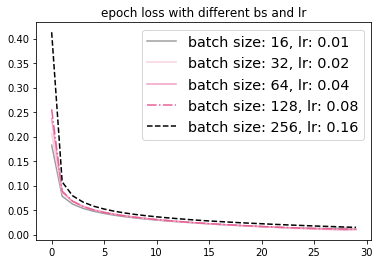

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# 绘制每个回合的损失
plt.plot(runner1.train_epoch_losses, label='batch size: 16, lr: 0.01', c='#9c9d9f')
plt.plot(runner2.train_epoch_losses, label='batch size: 32, lr: 0.02', c='#f7d2e2')
plt.plot(runner3.train_epoch_losses, label='batch size: 64, lr: 0.04', c='#f19ec2')
plt.plot(runner4.train_epoch_losses, label='batch size: 128, lr: 0.08', c='#e86096', linestyle='-.')
plt.plot(runner5.train_epoch_losses, label='batch size: 256, lr: 0.16', c='#000000', linestyle='--')
plt.legend(fontsize='x-large')
plt.title('epoch loss with different bs and lr')
plt.savefig('opt-mnist-loss.pdf')
plt.show()

从输出结果看，如果按每个回合的损失来看，每批次样本数越小，下降效果越明显。适当小的批大小可以导致更快的收敛。

**动手练习7.1**
* 尝试画出按迭代的损失变化图，观察不同的批大小在两种损失图中的下降效果是否相同。

**动手练习7.2**
* 对比下面两种实验设置，分析和比较它们的区别。1. 批大小增大一倍，学习率不变。2. 批大小不变，学习率减少一半。

## 7.3 不同优化算法的比较分析

除了批大小对模型收敛速度的影响外，学习率和梯度估计也是影响神经网络优化的重要因素。神经网络优化中常用的优化方法也主要是如下两方面的改进，包括：

* 学习率调整：主要通过自适应地调整学习率使得优化更稳定。这类算法主要有AdaGrad、RMSprop、AdaDelta算法等。
* 梯度估计修正：主要通过修正每次迭代时估计的梯度方向来加快收敛速度。这类算法主要有动量法、Nesterov加速梯度方法等。

除上述方法外，本节还会介绍综合学习率调整和梯度估计修正的优化算法，如Adam算法。

### 7.3.1 优化算法的实验设定

为了更好地对比不同的优化算法，我们准备两个实验：第一个是2D可视化实验。第二个是简单拟合实验。

首先介绍下这两个实验的任务设定。

#### 7.3.1.1 2D可视化实验

为了更好地展示不同优化算法的能力对比，我们选择一个二维空间中的凸函数，然后用不同的优化算法来寻找最优解，并可视化梯度下降过程的轨迹。

**被优化函数** 选择Sphere函数作为被优化函数，并对比它们的优化效果。Sphere函数的定义为
$$
\mathrm{sphere}(\bm x) = \sum_{d=1}^{D} x_d^2 = \bm x^2,
$$
其中$\bm x \in \mathbb{R}^D$，$\bm x^2$表示逐元素平方。Sphere函数有全局的最优点$\bm x^*=0$。

这里为了展示方便，我们使用二维的输入并略微修改Sphere函数，定义$\mathrm{sphere}(\bm x) = \bm w^\top \bm x^2$，并根据梯度下降公式计算对$\bm x$的偏导
$$
\frac{\partial \mathrm{sphere}(\bm x)}{\partial \bm x} = 2 \bm w \odot \bm x,
$$
其中$\odot$表示逐元素积。

将被优化函数实现为OptimizedFunction算子，其forward方法是Sphere函数的前向计算，backward方法则计算被优化函数对$\bm x$的偏导。代码实现如下：

In [5]:
from nndl.op import Op

class OptimizedFunction(Op):
    def __init__(self, w):
        super(OptimizedFunction, self).__init__()
        self.w = w
        self.params = {'x': 0}
        self.grads = {'x': 0}

    def forward(self, x):
        self.params['x'] = x
        return paddle.matmul(self.w.T, paddle.square(self.params['x']))

    def backward(self):
        self.grads['x'] = 2 * paddle.multiply(self.w.T, self.params['x'])

**小批量梯度下降优化器** 复用3.1.4.3节定义的梯度下降优化器SimpleBatchGD。按照梯度下降的梯度更新公式$\theta_t \leftarrow \theta_{t-1} - \alpha \mathbf g_t$进行梯度更新。

**训练函数**  定义一个简易的训练函数，记录梯度下降过程中每轮的参数$\bm x$和损失。代码实现如下：

In [6]:
def train_f(model, optimizer, x_init, epoch):
    """
    训练函数
    输入：
        - model：被优化函数
        - optimizer：优化器
        - x_init：x初始值
        - epoch：训练回合数
    """
    x = x_init
    all_x = []
    losses = []
    for i in range(epoch):
        all_x.append(x.numpy())
        loss = model(x)
        losses.append(loss)
        model.backward()
        optimizer.step()
        x = model.params['x']
    return paddle.to_tensor(all_x), losses

**可视化函数** 定义一个Visualization类，用于绘制$\bm x$的更新轨迹。代码实现如下：

In [7]:
class Visualization(object):
    def __init__(self):
        """
        初始化可视化类
        """
        # 只画出参数x1和x2在区间[-5, 5]的曲线部分
        x1 = np.arange(-5, 5, 0.1)
        x2 = np.arange(-5, 5, 0.1)
        x1, x2 = np.meshgrid(x1, x2)
        self.init_x = paddle.to_tensor([x1, x2])

    def plot_2d(self, model, x, fig_name):
        """
        可视化参数更新轨迹
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        cp = ax.contourf(self.init_x[0], self.init_x[1], model(self.init_x.transpose([1, 0, 2])), colors=['#e4007f', '#f19ec2', '#e86096', '#eb7aaa', '#f6c8dc', '#f5f5f5', '#000000'])
        c = ax.contour(self.init_x[0], self.init_x[1], model(self.init_x.transpose([1, 0, 2])), colors='black')
        cbar = fig.colorbar(cp)
        ax.plot(x[:, 0], x[:, 1], '-o', color='#000000')
        ax.plot(0, 'r*', markersize=18, color='#fefefe')

        ax.set_xlabel('$x1$')
        ax.set_ylabel('$x2$')

        ax.set_xlim((-2, 5))
        ax.set_ylim((-2, 5))
        plt.savefig(fig_name)

定义train_and_plot_f函数，调用train_f和Visualization，训练模型并可视化参数更新轨迹。代码实现如下：

In [8]:
import numpy as np

def train_and_plot_f(model, optimizer, epoch, fig_name):
    """
    训练模型并可视化参数更新轨迹
    """
    # 设置x的初始值
    x_init = paddle.to_tensor([3, 4], dtype='float32')
    print('x1 initiate: {}, x2 initiate: {}'.format(x_init[0].numpy(), x_init[1].numpy()))
    x, losses = train_f(model, optimizer, x_init, epoch)
    losses = np.array(losses)

    # 展示x1、x2的更新轨迹
    vis = Visualization()
    vis.plot_2d(model, x, fig_name)

**模型训练与可视化**  指定Sphere函数中$\bm w$的值，实例化被优化函数，通过小批量梯度下降法更新参数，并可视化$\bm x$的更新轨迹。

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


x1 initiate: [3.], x2 initiate: [4.]


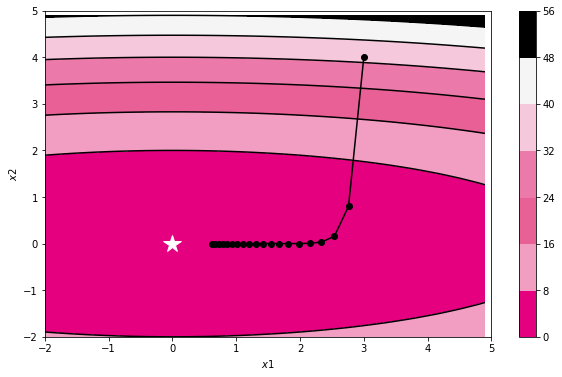

In [9]:
from nndl.op import SimpleBatchGD

# 固定随机种子
paddle.seed(0)
w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = SimpleBatchGD(init_lr=0.2, model=model)
train_and_plot_f(model, opt, epoch=20, fig_name='opti-vis-para.pdf')

输出图中不同颜色代表$f(x_1, x_2)$的值，具体数值可以参考图右侧的对应表，比如深粉色区域代表$f(x_1, x_2)$在0～8之间，不同颜色间黑色的曲线是等值线，代表落在该线上的点对应的$f(x_1, x_2)$的值都相同。

#### 7.3.1.2 简单拟合实验

除了2D可视化实验外，我们还设计一个简单的拟合任务，然后对比不同的优化算法。

这里我们随机生成一组数据作为数据样本，再构建一个简单的单层前馈神经网络，用于前向计算。

**数据集构建**  通过paddle.randn随机生成一些训练数据$\bm X$，并根据一个预定义函数$y = 0.5\times x_{1}+ 0.8\times x_{2} + 0.01\times noise$ 计算得到$\bm y$，再将$\bm X$和$\bm y$拼接起来得到训练样本。代码实现如下：

In [10]:
# 固定随机种子
paddle.seed(0)
# 随机生成shape为（1000，2）的训练数据
X = paddle.randn([1000, 2])
w = paddle.to_tensor([0.5, 0.8])
w = paddle.unsqueeze(w, axis=1)
noise = 0.01 * paddle.rand([1000])
noise = paddle.unsqueeze(noise, axis=1)
# 计算y
y = paddle.matmul(X, w) + noise
# 打印X, y样本
print('X: ', X[0].numpy())
print('y: ', y[0].numpy())

# X，y组成训练样本数据
data = paddle.concat((X, y), axis=1)
print('input data shape: ', data.shape)
print('data: ', data[0].numpy())

X:  [-4.080414  -1.3719953]
y:  [-3.136211]
input data shape:  [1000, 3]
data:  [-4.080414  -1.3719953 -3.136211 ]


**模型构建**  定义单层前馈神经网络，$\bm X \in \mathbb{R}^{N \times D}$为网络输入, $\bm w \in \mathbb{R}^{D}$是网络的权重矩阵，$\bm b \in \mathbb{R}$为偏置。
$$
\bm y =\bm X \bm w + b \in \mathbb{R}^{K\times 1},
$$

其中$K$代表一个批次中的样本数量，$D$为单层网络的输入特征维度。

**损失函数**  使用均方误差作为训练时的损失函数，计算损失函数关于参数$\bm w$和$b$的偏导数。定义均方误差损失函数的计算方法为
$$
\mathcal{L} = \frac{1}{2K}\sum_{k=1}^K(\bm y^{(k)} - \bm z^{(k)})^2,
$$

其中$\bm z^{(k)}$是网络对第$k$个样本的预测值。根据损失函数关于参数的偏导公式，得到$\mathcal{L}(\cdot)$对于参数$\bm w$和$b$的偏导数，
$$
    \frac{\partial \mathcal{L}}{\partial \bm w} = \frac{1}{K}\sum_{k=1}^K\bm x^{(k)}(\bm z^{(k)} - \bm y^{(k)}) = \frac{1}{K}\bm X^\top(\bm z - \bm y), \\
    \frac{\partial \mathcal{L}}{\partial b} = \frac{1}{K}\sum_{k=1}^K(\bm z^{(k)} - \bm y^{(k)}) = \frac{1}{K}\mathbf{1}^\top(\bm z - \bm y).
$$

定义Linear算子，实现一个线性层的前向和反向计算。代码实现如下：

In [11]:
class Linear(Op):
    def __init__(self, input_size, weight_init=paddle.standard_normal, bias_init=paddle.zeros):
        super(Linear, self).__init__()
        self.params = {}
        self.params['W'] = weight_init(shape=[input_size, 1])
        self.params['b'] = bias_init(shape=[1])
        self.inputs = None
        self.grads = {}

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = paddle.matmul(self.inputs, self.params['W']) + self.params['b']
        return self.outputs

    def backward(self, labels):
        K = self.inputs.shape[0]
        self.grads['W'] = 1. /K * paddle.matmul(self.inputs.T, (self.outputs - labels))
        self.grads['b'] = 1. /K * paddle.sum(self.outputs - labels, axis=0)

**笔记**

这里backward函数中实现的梯度并不是forward函数对应的梯度，而是最终损失关于参数的梯度．由于这里的梯度是手动计算的，所以直接给出了最终的梯度。

**训练函数**  在准备好样本数据和网络以后，复用优化器SimpleBatchGD类，使用小批量梯度下降来进行简单的拟合实验。

这里我们重新定义模型训练train函数。主要以下两点原因：
* 在一般的随机梯度下降中要在每回合迭代开始之前随机打乱训练数据的顺序，再按批大小进行分组。这里为了保证每次运行结果一致以便更好地对比不同的优化算法，这里不再随机打乱数据。
* 与RunnerV2中的训练函数相比，这里使用小批量梯度下降。而与RunnerV3中的训练函数相比，又通过继承优化器基类Optimizer实现不同的优化器。

模型训练train函数的代码实现如下：

In [12]:
def train(data, num_epochs, batch_size, model, calculate_loss, optimizer, verbose=False):
    """
    训练神经网络
    输入：
        - data：训练样本
        - num_epochs：训练回合数
        - batch_size：批大小
        - model：实例化的模型
        - calculate_loss：损失函数
        - optimizer：优化器
        - verbose：日志显示，默认为False
    输出：
        - iter_loss：每一次迭代的损失值
        - epoch_loss：每个回合的平均损失值
    """
    # 记录每个回合损失的变化
    epoch_loss = []
    # 记录每次迭代损失的变化
    iter_loss = []
    N = len(data)
    for epoch_id in range(num_epochs):
        # np.random.shuffle(data) #不再随机打乱数据
        # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
        mini_batches = [data[i:i+batch_size] for i in range(0, N, batch_size)]
        for iter_id, mini_batch in enumerate(mini_batches):
            # data中前两个分量为X
            inputs = mini_batch[:, :-1]
            # data中最后一个分量为y
            labels = mini_batch[:, -1:]
            # 前向计算
            outputs = model(inputs)
            # 计算损失
            loss = calculate_loss(outputs, labels).numpy()[0]
            # 计算梯度
            model.backward(labels)
            # 梯度更新
            optimizer.step()
            iter_loss.append(loss)
        # verbose = True 则打印当前回合的损失
        if verbose:
            print('Epoch {:3d}, loss = {:.4f}'.format(epoch_id, np.mean(iter_loss)))
        epoch_loss.append(np.mean(iter_loss))
    return iter_loss, epoch_loss

**优化过程可视化**  定义plot_loss函数，用于绘制损失函数变化趋势。代码实现如下：

In [13]:
def plot_loss(iter_loss, epoch_loss, fig_name):
    """
    可视化损失函数的变化趋势
    """
    plt.figure(figsize=(10, 4))
    ax1 = plt.subplot(121)
    ax1.plot(iter_loss, color='#e4007f')
    plt.title('iteration loss')
    ax2 = plt.subplot(122)
    ax2.plot(epoch_loss, color='#f19ec2')
    plt.title('epoch loss')
    plt.savefig(fig_name)
    plt.show()

对于使用不同优化器的模型训练，保存每一个回合损失的更新情况，并绘制出损失函数的变化趋势，以此验证模型是否收敛。定义train_and_plot函数，调用train和plot_loss函数，训练并展示每个回合和每次迭代(Iteration)的损失变化情况。在模型训练时，使用paddle.nn.MSELoss()计算均方误差。代码实现如下：

In [14]:
import paddle.nn as nn
def train_and_plot(optimizer, fig_name):
    """
    训练网络并画出损失函数的变化趋势
    输入：
        - optimizer：优化器
    """
    # 定义均方差损失
    mse = nn.MSELoss()
    iter_loss, epoch_loss = train(data, num_epochs=30, batch_size=64, model=model, calculate_loss=mse, optimizer=optimizer)
    plot_loss(iter_loss, epoch_loss, fig_name)

训练网络并可视化损失函数的变化趋势。代码实现如下：

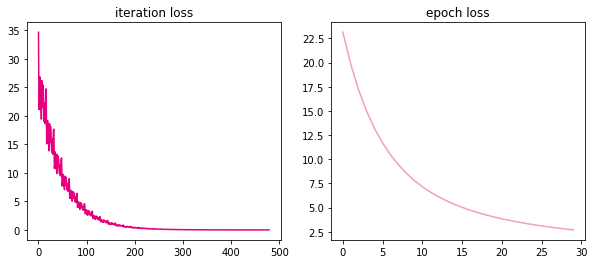

In [15]:
# 固定随机种子
paddle.seed(0)
# 定义网络结构
model = Linear(2)
# 定义优化器
opt = SimpleBatchGD(init_lr=0.01, model=model)
train_and_plot(opt, 'opti-loss.pdf')

从输出结果看，loss在不断减小，模型逐渐收敛。

**提醒**  
在本小节中，我们定义了两个实验：2D可视化实验和简单拟合实验。这两个实验会在本节介绍的所有优化算法中反复使用，以便进行对比。

**与Paddle API对比，验证正确性**

分别实例化自定义SimpleBatchGD优化器和调用paddle.optimizer.SGD API, 验证自定义优化器的正确性。

In [16]:
paddle.seed(0)

x = data[0, :-1].unsqueeze(0)
y = data[0, -1].unsqueeze(0)

model1 = Linear(2)
print('model1 parameter W: ', model1.params['W'].numpy())
opt1 = SimpleBatchGD(init_lr=0.01, model=model1)
output1 = model1(x)

model2 = nn.Linear(2, 1, paddle.nn.initializer.Assign(model1.params['W']))
print('model2 parameter W: ', model2.state_dict()['weight'].numpy())
output2 = model2(x)

model1.backward(y)
opt1.step()
print('model1 parameter W after train step: ', model1.params['W'].numpy())

opt2 = optimizer.SGD(learning_rate=0.01, parameters=model2.parameters())
loss = paddle.nn.functional.mse_loss(output2, y) / 2
loss.backward()
opt2.step()
opt2.clear_grad()
print('model2 parameter W after train step: ', model2.state_dict()['weight'].numpy())

model1 parameter W:  [[-4.080414 ]
 [-1.3719953]]
model2 parameter W:  [[-4.080414 ]
 [-1.3719953]]
model1 parameter W after train step:  [[-3.196255 ]
 [-1.0747064]]
model2 parameter W after train step:  [[-3.196255 ]
 [-1.0747064]]


从输出结果看，在一次梯度更新后，两个模型的参数值保持一致，证明优化器实现正确。

### 7.3.2 学习率调整

学习率是神经网络优化时的重要超参数。在梯度下降法中，学习率$\alpha$的取值非常关键，如果取值过大就不会收敛，如果过小则收敛速度太慢。

常用的学习率调整方法包括如下几种方法：
* 学习率衰减：如分段常数衰减（Piecewise Constant Decay）、余弦衰减（Cosine Decay）等；
* 学习率预热：如逐渐预热(Gradual Warmup) 等；
* 周期性学习率调整：如循环学习率等；
* 自适应调整学习率的方法：如AdaGrad、RMSprop、AdaDelta等。自适应学习率方法可以针对每个参数设置不同的学习率。

**动手练习7.2**  
尝试《神经网络与深度学习》中第7.2.3.1节中定义的不同学习率衰减方法，重复上面的实验并分析实验结果。

下面我们来详细介绍AdaGrad和RMSprop算法。

#### 7.3.2.1 AdaGrad算法

AdaGrad算法（Adaptive Gradient Algorithm，自适应梯度算法)是借鉴 $\ell_2$ 正则化的思想，每次迭代时自适应地调整每个参数的学习率。在第$t$次迭代时，先计算每个参数梯度平方的累计值。
$$
G_t = \sum^t_{\tau=1} \mathbf g_{\tau} \odot \mathbf g_{\tau},
$$
其中$\odot$为按元素乘积，$\mathbf g_{\tau} \in \mathbb R^{\mid \theta \mid}$是第$\tau$次迭代时的梯度。
$$
\Delta \theta_t = - \frac{\alpha}{\sqrt{G_t + \epsilon}} \odot \mathbf g_{t},
$$
其中$\alpha$是初始的学习率，$\epsilon$是为了保持数值稳定性而设置的非常小的常数，一般取值$e^{−7}$到$e^{−10}$。此外，这里的开平方、除、加运算都是按元素进行的操作。

**构建优化器**  定义Adagrad类，继承Optimizer类。定义step函数调用adagrad进行参数更新。代码实现如下：

In [17]:
from nndl.op import Optimizer

class Adagrad(Optimizer):
    def __init__(self, init_lr, model, epsilon):
        """
        Adagrad 优化器初始化
        输入：
            - init_lr： 初始学习率
            - model：模型，model.params存储模型参数值
            - epsilon：保持数值稳定性而设置的非常小的常数
        """
        super(Adagrad, self).__init__(init_lr=init_lr, model=model)
        self.G = {}
        for key in self.model.params.keys():
            self.G[key] = 0
        self.epsilon = epsilon

    def adagrad(self, x, gradient_x, G, init_lr):
        """
        adagrad算法更新参数，G为参数梯度平方的累计值。
        """
        G += gradient_x ** 2
        x -= init_lr / paddle.sqrt(G + self.epsilon) * gradient_x
        return x, G

    def step(self):
        """
        参数更新
        """
        for key in self.model.params.keys():
            self.model.params[key], self.G[key] = self.adagrad(self.model.params[key], 
                                                               self.model.grads[key], 
                                                               self.G[key], 
                                                               self.init_lr)                

**2D可视化实验**  使用被优化函数展示Adagrad算法的参数更新轨迹。代码实现如下：

x1 initiate: [3.], x2 initiate: [4.]


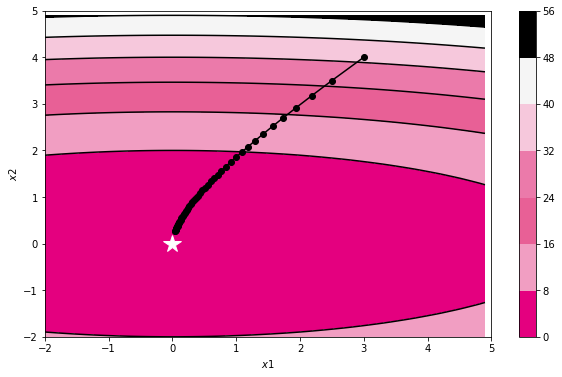

In [18]:
# 固定随机种子
paddle.seed(0)
w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = Adagrad(init_lr=0.5, model=model, epsilon=1e-7)
train_and_plot_f(model, opt, epoch=50, fig_name='opti-vis-para2.pdf')

从输出结果看，AdaGrad算法在前几个回合更新时参数更新幅度较大，随着回合数增加，学习率逐渐缩小，参数更新幅度逐渐缩小。在AdaGrad算法中，如果某个参数的偏导数累积比较大，其学习率相对较小。相反，如果其偏导数累积较小，其学习率相对较大。但整体随着迭代次数的增加，学习率逐渐缩小。该算法的缺点是在经过一定次数的迭代依然没有找到最优点时，由于这时的学习率已经非常小，很难再继续找到最优点。

**简单拟合实验**  训练单层线性网络，验证损失是否收敛。代码实现如下：

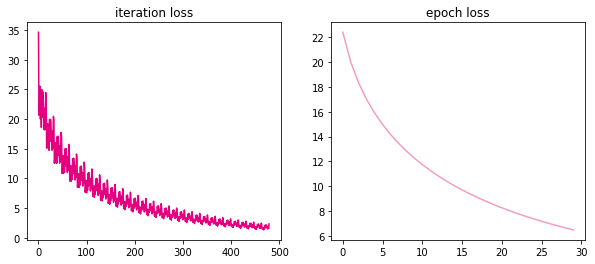

In [19]:
# 固定随机种子
paddle.seed(0)
# 定义网络结构
model = Linear(2)
# 定义优化器
opt = Adagrad(init_lr=0.1, model=model, epsilon=1e-7)
train_and_plot(opt, 'opti-loss2.pdf')

#### 7.3.2.2 RMSprop算法

RMSprop算法是一种自适应学习率的方法，可以在有些情况下避免AdaGrad算法中学习率不断单调下降以至于过早衰减的缺点。

RMSprop算法首先计算每次迭代梯度平方$\mathbf g_{t}^{2}$的加权移动平均
$$
G_t = \beta G_{t-1} + (1 - \beta) \mathbf g_t \odot \mathbf g_t,
$$
其中$\beta$为衰减率，一般取值为0.9。

RMSprop算法的参数更新差值为：
$$
\Delta \theta_t = - \frac{\alpha}{\sqrt{G_t + \epsilon}} \odot \mathbf g_t,
$$
其中$\alpha$是初始的学习率，比如0.001。RMSprop算法和AdaGrad算法的区别在于RMSprop算法中$G_t$的计算由累积方式变成了加权移动平均。在迭代过程中，每个参数的学习率并不是呈衰减趋势，既可以变小也可以变大。

**构建优化器**  定义RMSprop类，继承Optimizer类。定义step函数调用rmsprop更新参数。代码实现如下：

In [20]:
class RMSprop(Optimizer):
    def __init__(self, init_lr, model, beta, epsilon):
        """
        RMSprop优化器初始化
        输入：
            - init_lr：初始学习率
            - model：模型，model.params存储模型参数值
            - beta：衰减率
            - epsilon：保持数值稳定性而设置的常数
        """
        super(RMSprop, self).__init__(init_lr=init_lr, model=model)
        self.G = {}
        for key in self.model.params.keys():
            self.G[key] = 0
        self.beta = beta
        self.epsilon = epsilon

    def rmsprop(self, x, gradient_x, G, init_lr):
        """
        rmsprop算法更新参数，G为迭代梯度平方的加权移动平均
        """
        G = self.beta * G + (1 - self.beta) * gradient_x ** 2
        x -= init_lr / paddle.sqrt(G + self.epsilon) * gradient_x
        return x, G

    def step(self):
        """参数更新"""
        for key in self.model.params.keys():
            self.model.params[key], self.G[key] = self.rmsprop(self.model.params[key], 
                                                               self.model.grads[key],
                                                               self.G[key], 
                                                               self.init_lr)

**2D可视化实验**  使用被优化函数展示RMSprop算法的参数更新轨迹。代码实现如下：

x1 initiate: [3.], x2 initiate: [4.]


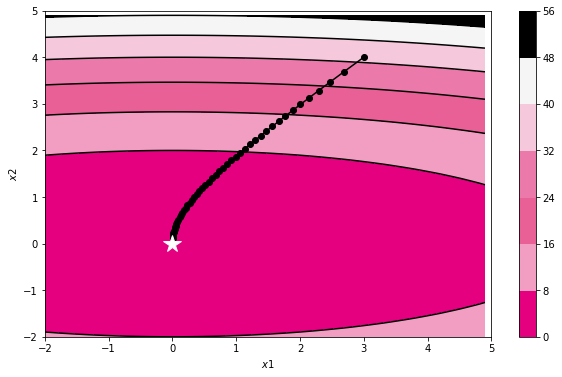

In [21]:
# 固定随机种子
paddle.seed(0)
w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = RMSprop(init_lr=0.1, model=model, beta=0.9, epsilon=1e-7)
train_and_plot_f(model, opt, epoch=50, fig_name='opti-vis-para3.pdf')

**简单拟合实验**  训练单层线性网络，进行简单的拟合实验。代码实现如下：

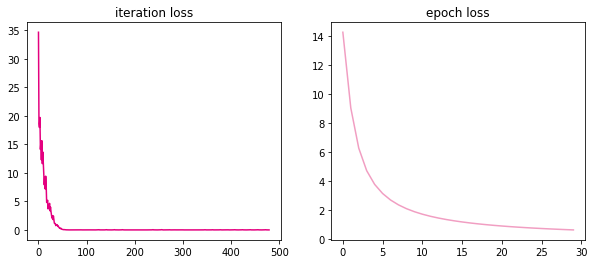

In [22]:
# 固定随机种子
paddle.seed(0)
# 定义网络结构
model = Linear(2)
# 定义优化器
opt = RMSprop(init_lr=0.1, model=model, beta=0.9, epsilon=1e-7)
train_and_plot(opt, 'opti-loss3.pdf')

**动手练习7.4**

动手实现AdaDelta算法。

### 7.3.3 梯度估计修正
除了调整学习率之外，还可以进行梯度估计修正。在小批量梯度下降法中，由于每次迭代的样本具有一定的随机性，因此每次迭代的梯度估计和整个训练集上的最优梯度并不一致。如果每次选取样本数量比较小，损失会呈振荡的方式下降。

一种有效地缓解梯度估计随机性的方式是通过使用最近一段时间内的平均梯度来代替当前时刻的随机梯度来作为参数更新的方向，从而提高优化速度。

#### 7.3.3.1 动量法

动量法（Momentum Method）是用之前积累动量来替代真正的梯度。每次迭代的梯度可以看作加速度。

在第$t$次迭代时，计算负梯度的“加权移动平均”作为参数的更新方向，

$$
\Delta \theta_t = \rho \Delta \theta_{t-1} - \alpha \mathbf g_t = - \alpha \sum_{\tau=1}^t\rho^{t - \tau} \mathbf g_{\tau},
$$
其中$\rho$为动量因子，通常设为0.9，$\alpha$为学习率。

这样，每个参数的实际更新差值取决于最近一段时间内梯度的加权平均值。当某个参数在最近一段时间内的梯度方向不一致时，其真实的参数更新幅度变小。相反，当某个参数在最近一段时间内的梯度方向都一致时，其真实的参数更新幅度变大，起到加速作用。一般而言，在迭代初期，梯度方向都比较一致，动量法会起到加速作用，可以更快地到达最优点。在迭代后期，梯度方向会不一致，在收敛值附近振荡，动量法会起到减速作用，增加稳定性。从某种角度来说，当前梯度叠加上部分的上次梯度，一定程度上可以近似看作二阶梯度。

**构建优化器**  定义Momentum类，继承Optimizer类。定义step函数调用momentum进行参数更新。代码实现如下：

In [23]:
class Momentum(Optimizer):
    def __init__(self, init_lr, model, rho):
        """
        Momentum优化器初始化
        输入：
            - init_lr：初始学习率
            - model：模型，model.params存储模型参数值
            - rho：动量因子
        """
        super(Momentum, self).__init__(init_lr=init_lr, model=model)
        self.delta_x = {}
        for key in self.model.params.keys():
            self.delta_x[key] = 0
        self.rho = rho

    def momentum(self, x, gradient_x, delta_x, init_lr):
        """
        momentum算法更新参数，delta_x为梯度的加权移动平均
        """
        delta_x = self.rho * delta_x - init_lr * gradient_x
        x += delta_x
        return x, delta_x

    def step(self):
        """参数更新"""
        for key in self.model.params.keys():
            self.model.params[key], self.delta_x[key] = self.momentum(self.model.params[key], 
                                                                      self.model.grads[key], 
                                                                      self.delta_x[key], 
                                                                      self.init_lr) 

**2D可视化实验**  使用被优化函数展示Momentum算法的参数更新轨迹。

x1 initiate: [3.], x2 initiate: [4.]


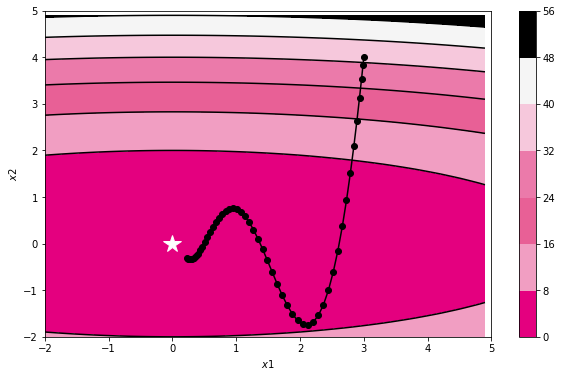

In [24]:
# 固定随机种子
paddle.seed(0)
w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = Momentum(init_lr=0.01, model=model, rho=0.9)
train_and_plot_f(model, opt, epoch=50, fig_name='opti-vis-para4.pdf')

从输出结果看，在模型训练初期，梯度方向比较一致，参数更新幅度逐渐增大，起加速作用；在迭代后期，参数更新幅度减小，在收敛值附近振荡。

**简单拟合实验**  训练单层线性网络，进行简单的拟合实验。代码实现如下：

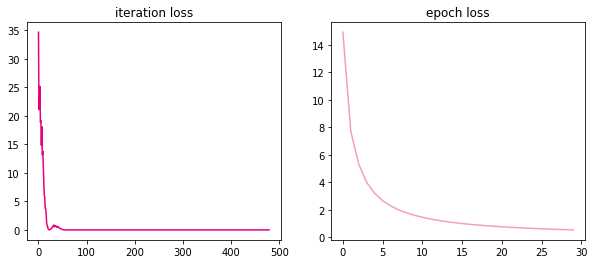

In [25]:
# 固定随机种子
paddle.seed(0)

# 定义网络结构
model = Linear(2)
# 定义优化器
opt = Momentum(init_lr=0.01, model=model, rho=0.9)
train_and_plot(opt, 'opti-loss4.pdf')

#### 7.3.3.2 Adam算法

Adam算法（Adaptive Moment Estimation Algorithm，自适应矩估计算法）可以看作动量法和RMSprop算法的结合，不但使用动量作为参数更新方向，而且可以自适应调整学习率。

Adam算法一方面计算梯度平方$\mathbf g_t^2$的加权移动平均（和RMSprop算法类似），另一方面计算梯度$\mathbf g_t$的加权移动平均（和动量法类似）。

$$
M_t = \beta_1 M_{t-1} + (1 - \beta_1)\mathbf g_t,  \\
G_t = \beta_2 G_{t-1} + (1 - \beta_2)\mathbf g_t \odot \mathbf g_t,
$$
其中$\beta_1$和$\beta_2$分别为两个移动平均的衰减率，通常取值为$\beta_1 = 0.9, \beta_2 = 0.99$。我们可以把$M_t$和$G_t$分别看作梯度的均值(一阶矩)和未减去均值的方差(二阶矩)。

假设$M_0 = 0, G_0 = 0$，那么在迭代初期$M_t$和$G_t$的值会比真实的均值和方差要小。特别是当$\beta_1$和$\beta_2$都接近于1时，偏差会很大。因此，需要对偏差进行修正。
$$
\hat M_t = \frac{M_t}{1 - \beta^t_1},  \\
\hat G_t = \frac{G_t}{1 - \beta^t_2}。
$$

Adam算法的参数更新差值为
$$
\Delta \theta_t = - \frac{\alpha}{\sqrt{\hat G_t + \epsilon}}\hat M_t,
$$
其中学习率$\alpha$通常设为0.001，并且也可以进行衰减，比如$a_t = \frac{a_0}{\sqrt{t}}$。

**构建优化器**  定义Adam类，继承Optimizer类。定义step函数调用adam函数更新参数。代码实现如下：

In [26]:
class Adam(Optimizer):
    def __init__(self, init_lr, model, beta1, beta2, epsilon):
        """
        Adam优化器初始化
        输入：
            - init_lr：初始学习率
            - model：模型，model.params存储模型参数值
            - beta1, beta2：移动平均的衰减率
            - epsilon：保持数值稳定性而设置的常数
        """
        super(Adam, self).__init__(init_lr=init_lr, model=model)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.M, self.G = {}, {}
        for key in self.model.params.keys():
            self.M[key] = 0
            self.G[key] = 0
        self.t = 1

    def adam(self, x, gradient_x, G, M, t, init_lr):
        """
        adam算法更新参数
        输入：
            - x：参数
            - G：梯度平方的加权移动平均
            - M：梯度的加权移动平均
            - t：迭代次数
            - init_lr：初始学习率
        """
        M = self.beta1 * M + (1 - self.beta1) * gradient_x
        G = self.beta2 * G + (1 - self.beta2) * gradient_x ** 2
        M_hat = M / (1 - self.beta1 ** t)
        G_hat = G / (1 - self.beta2 ** t)
        t += 1
        x -= init_lr / paddle.sqrt(G_hat + self.epsilon) * M_hat
        return x, G, M, t

    def step(self):
        """参数更新"""
        for key in self.model.params.keys():
            self.model.params[key], self.G[key], self.M[key], self.t = self.adam(self.model.params[key], 
                                                                                 self.model.grads[key],
                                                                                 self.G[key], 
                                                                                 self.M[key],
                                                                                 self.t, 
                                                                                 self.init_lr)


                                                                                 

**2D可视化实验** 使用被优化函数展示Adam算法的参数更新轨迹。代码实现如下：

x1 initiate: [3.], x2 initiate: [4.]


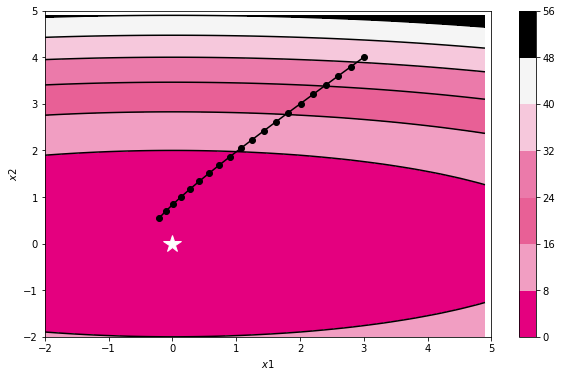

In [27]:
# 固定随机种子
paddle.seed(0)
w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = Adam(init_lr=0.2, model=model, beta1=0.9, beta2=0.99, epsilon=1e-7)
train_and_plot_f(model, opt, epoch=20, fig_name='opti-vis-para5.pdf')

从输出结果看，Adam算法可以自适应调整学习率，参数更新更加平稳。

**简单拟合实验**  训练单层线性网络，进行简单的拟合实验。代码实现如下：

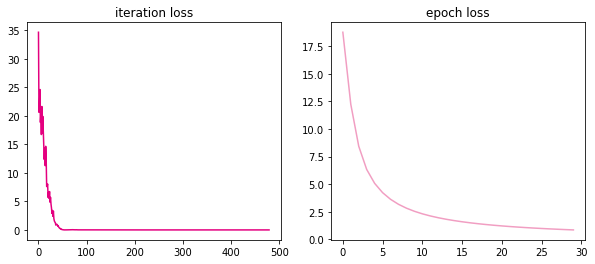

In [28]:
# 固定随机种子
paddle.seed(0)
# 定义网络结构
model = Linear(2)
# 定义优化器
opt = Adam(init_lr=0.1, model=model, beta1=0.9, beta2=0.99, epsilon=1e-7)
train_and_plot(opt, 'opti-loss5.pdf')

**动手练习7.5**

学习AdamW算法，通过飞桨 API调用LeNet网络和MNIST数据集，使用paddle.optimizer.AdamW作为优化器训练网络，进行简单的拟合实验。

### 7.3.4 不同优化器的3D可视化对比
#### 7.3.4.1 构建一个三维空间中的被优化函数
定义OptimizedFunction3D算子，表示被优化函数$f(\bm x) = \bm x[0]^2 + \bm x[1]^2 + \bm x[1]^3 + \bm x[0]*\bm x[1]$，其中$\bm x[0]$, $\bm x[1]$代表两个参数。该函数在(0,0)处存在鞍点，即一个既不是极大值点也不是极小值点的临界点。希望训练过程中，优化算法可以使参数离开鞍点，向模型最优解收敛。代码实现如下：

In [29]:
class OptimizedFunction3D(Op):
    def __init__(self):
        super(OptimizedFunction3D, self).__init__()
        self.params = {'x': 0}
        self.grads = {'x': 0}

    def forward(self, x):
        self.params['x'] = x
        return x[0] ** 2 + x[1] ** 2 + x[1] ** 3 + x[0]*x[1]

    def backward(self):
        x = self.params['x']
        gradient1 = 2 * x[0] + x[1]
        gradient2 = 2 * x[1] + 3 * x[1] ** 2 + x[0]
        self.grads['x'] = paddle.concat([gradient1, gradient2])

对于相同的被优化函数，分别使用不同的优化器进行参数更新，并保存不同优化器下参数更新的值，用于可视化。代码实现如下：

In [30]:
# 构建5个模型，分别配备不同的优化器
model1 = OptimizedFunction3D()
opt_gd = SimpleBatchGD(init_lr=0.01, model=model1)

model2 = OptimizedFunction3D()
opt_adagrad = Adagrad(init_lr=0.5, model=model2, epsilon=1e-7)

model3 = OptimizedFunction3D()
opt_rmsprop = RMSprop(init_lr=0.1, model=model3, beta=0.9, epsilon=1e-7)

model4 = OptimizedFunction3D()
opt_momentum = Momentum(init_lr=0.01, model=model4, rho=0.9)

model5 = OptimizedFunction3D()
opt_adam = Adam(init_lr=0.1, model=model5, beta1=0.9, beta2=0.99, epsilon=1e-7)

models = [model1, model2, model3, model4, model5]
opts = [opt_gd, opt_adagrad, opt_rmsprop, opt_momentum, opt_adam]

x_all_opts = []
z_all_opts = []
x_init = paddle.to_tensor([2, 3], dtype='float32')
# 使用不同优化器训练
for model, opt in zip(models, opts):
    x_one_opt, z_one_opt = train_f(model, opt, x_init, 150)
    # 保存参数值
    x_all_opts.append(x_one_opt.numpy())
    z_all_opts.append(np.squeeze(z_one_opt))

定义Visualization3D函数，用于可视化三维的参数更新轨迹。

In [31]:
from matplotlib import animation
from itertools import zip_longest

class Visualization3D(animation.FuncAnimation):
    """
    绘制动态图像，可视化参数更新轨迹
    """
    def __init__(self, *xy_values, z_values, labels=[], colors=[], fig, ax, interval=60, blit=True, **kwargs):
        """
        初始化3d可视化类
        输入：
            xy_values：三维中x,y维度的值
            z_values：三维中z维度的值
            labels：每个参数更新轨迹的标签
            colors：每个轨迹的颜色
            interval：帧之间的延迟（以毫秒为单位）
            blit：是否优化绘图
        """
        self.fig = fig
        self.ax = ax
        self.xy_values = xy_values
        self.z_values = z_values
        frames = max(xy_value.shape[0] for xy_value in xy_values)
        self.lines = [ax.plot([], [], [], label=label, color=color, lw=2)[0]
                      for _, label, color in zip_longest(xy_values, labels, colors)]
        super(Visualization3D, self).__init__(fig, self.animate, init_func=self.init_animation, frames=frames, interval=interval, blit=blit, **kwargs)

    def init_animation(self):
        # 数值初始化
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        # 将x,y,z三个数据传入，绘制三维图像
        for line, xy_value, z_value in zip(self.lines, self.xy_values, self.z_values):
            line.set_data(xy_value[:i, 0], xy_value[:i, 1])
            line.set_3d_properties(z_value[:i])
        return self.lines

绘制出被优化函数的三维图像。代码实现如下：

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


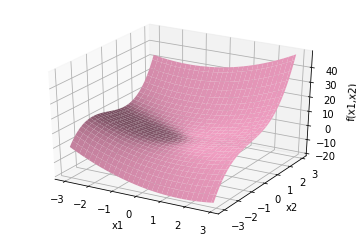

In [32]:
from mpl_toolkits.mplot3d import Axes3D

# 使用numpy.meshgrid生成x1,x2矩阵，矩阵的每一行为[-3, 3]，以0.1为间隔的数值
x1 = np.arange(-3, 3, 0.1)
x2 = np.arange(-3, 3, 0.1)
x1, x2 = np.meshgrid(x1, x2)
init_x = paddle.to_tensor([x1, x2])
model = OptimizedFunction3D()

# 绘制f_3d函数的三维图像
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(init_x[0], init_x[1], model(init_x), color='#f19ec2')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1,x2)')
plt.savefig('opti-f-3d.pdf')

可视化不同优化器情况下参数变化轨迹。

In [81]:
from IPython.display import HTML

labels = ['SGD', 'AdaGrad', 'RMSprop', 'Momentum', 'Adam']
colors = ['#9c9d9f', '#f7d2e2', '#f19ec2', '#e86096', '#000000']

anim = Visualization3D(*x_all_opts, z_values=z_all_opts, labels=labels, colors=colors, fig=fig, ax=ax)
ax.legend(loc='upper left')
HTML(anim.to_html5_video())

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:141: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


从输出结果看，对于我们构建的函数，有些优化器如Momentum在参数更新时成功逃离鞍点，其他优化器在本次实验中收敛到鞍点处没有成功逃离。但这并不证明Momentum优化器是最好的优化器，在模型训练时使用哪种优化器，还要结合具体的场景和数据具体分析。

**动手练习7.6**  
通过调用飞桨API, 实验比较不同优化算法在MNIST数据集上的收敛性。

# 7.4 参数初始化

神经网络的参数学习是一个非凸优化问题。当使用梯度下降法来进行网络参数优化时，参数初始值的选取十分关键，关系到网络的优化效率和泛化能力。此外，由于神经网络优化时出现的对称权重现象（参见第4.4.1节），神经网络的参数不能初始化为相同的值，需要有一定的差异性。

常用的参数初始化的方式通常有以下三种：
* 随机初始化：最常用的参数初始化策略，通过一个随机采样函数来生成每个参数的初始值。
* 预训练初始化：一种在实践中经常使用的初始化策略，如果目标任务的训练数据不足，可以使用一个已经在大规模数据上训练过的模型作为参数初始值。预训练模型在目标任务上的学习过程也称为精调Fine-Tuning。
* 固定值初始化：对于神经网络中的某些重要参数，可以根据先验知识来初始化。比如对于使用ReLU激活函数的全连接层，其偏置通常可以设为比较小的正数（比如0.01），从而确保这一层的神经元的梯度不为0，避免死亡ReLU现象。

虽然预训练初始化通常具有更好的收敛性和泛化性，但是灵活性不够，不能在目标任务上任意地调整网络结构。因此，好的随机初始化方法对训练神经网络模型来说依然十分重要。在本节我们主要介绍两种随机初始化方法：基于固定方差的参数初始化和基于方差缩放的参数初始化。

### 7.4.1 基于固定方差的参数初始化

一种最简单的随机初始化方法是从一个固定均值(通常为 0)和方差$\sigma^2$的分布中采样来生成参数的初始值。基于固定方差的参数初始化方法主要有高斯分布初始化和均匀分布初始化两种：

* 高斯分布初始化：使用一个高斯分布$\mathscr{N}(0, \sigma^2)$对每个参数进行随机初始化。
* 均匀分布初始化：在一个给定的区间$[-r, r]$内采用均匀分布来初始化。

高斯分布和均匀分布初始化的实现方式可以参考第4.4.1节参数初始化代码。

### 7.4.2 基于方差缩放的参数初始化

初始化一个深度网络时，为了缓解梯度消失或爆炸问题，我们尽可能保持每个神经元的输入和输出的方差一致，根据神经元的连接数量来自适应地调整初始化分布的方差，这类方法称为方差缩放（Variance Scaling）。


Xavier初始化是参数初始化中常用的方法，根据每层的神经元数量来自动计算初始化参数方差。
在计算出参数的理想方差后，可以通过高斯分布或均匀分布来随机初始化参数。若神经元采用Tanh函数，并采用高斯分布来随机初始化参数，连接权重$w_i^{(l)}$可以按$\mathscr{N}(0, \frac{2}{M_{l-1} + M_l})$的高斯分布进行初始化，其中$M_{l-1}$是第$l-1$层神经元个数。

**笔记**

Xavier初始化公式推导可参考《神经网络与深度学习》7.3.2.1 Xavier初始化。

本节动手实现Xavier初始化，并观察其效果。

#### 7.4.2.1 模型构建

首先定义xavier_normal_std函数，根据$l$层和$l-1$层神经元的数量计算理想标准差。值得注意的是，在paddle.normal API中，通过指定标准差的值来生成符合正态分布的张量，因此，这里需要计算标准差。代码实现如下：

In [34]:
def xavier_normal_std(input_size, output_size):
    return np.sqrt(2 / (input_size + output_size))

**笔记**

Xavier初始化适用于Logistic激活函数和Tanh激活函数，对于不同激活函数，高斯分布的方差和均匀分布的$r$值计算是不同的。xavier_normal_std定义针对Tanh激活函数的情况。

定义一个全连接前馈网络（即多层感知器）MLP算子，实例化网络时可以通过layers_size指定网络每层神经元的数量，通过init_fn_name指定网络中参数初始化方法(Xavier高斯分布初始化、Xavier均匀分布初始化或$\mathscr{N}(0, 1)$高斯分布初始化)，init_fn指定计算初始化时均值或数值范围的函数，act_fn指定激活函数。代码实现如下：

In [35]:
class MLP(nn.Layer):
    def __init__(self, layers_size, init_fn_name, init_fn, act_fn):
        """
        多层网络初始化
        输入：
            - layers_size: 每层神经元的数量
            - init_fn_name: 网络中参数初始化方法，可以为 'normal'或'uniform'
            - init_fn: 函数，用来计算高斯分布标准差或均匀分布r值
            - act_fn: 激活函数
        """
        super(MLP, self).__init__()
        self.linear = nn.Sequential()
        self.num_layers = len(layers_size) - 1
        for i in range(self.num_layers):
            input_size, output_size = layers_size[i], layers_size[i + 1]
            if init_fn_name == 'normal':
                # Xavier高斯分布初始化，计算方差
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size,
                                           weight_attr=nn.initializer.Normal(mean=0, std=init_fn(input_size, output_size))))
            elif init_fn_name == 'uniform':
                r = init_fn(input_size, output_size)
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size, weight_attr=nn.initializer.Uniform(low=-r, high=r)))
            else:
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size, weight_attr=nn.initializer.Normal()))
        self.act_fn = act_fn()
        self.z = {}

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        """
        前向计算
        """
        y = X
        for num_layer in range(self.num_layers):
            y = self.linear[num_layer](y)
            if num_layer != self.num_layers - 1:
                y = self.act_fn(y)
            self.z[num_layer] = y
        return y

#### 7.4.2.2 观察模型神经元的方差变化
**高斯分布初始化**  定义网络每层神经元的数量，指定激活函数和参数初始化方式，通过Xavier高斯分布初始化网络。代码实现如下:

In [36]:
paddle.seed(0)

# 定义网络每层神经元的数量
layers_size = [100, 200, 400, 300, 200, 100]
# 指定激活函数
activate_fn = paddle.nn.Tanh
# 指定参数初始化方式
init_fn_name = 'normal'

model = MLP(layers_size, init_fn_name, init_fn=xavier_normal_std, act_fn=activate_fn)
inputs = paddle.normal(shape=[1, 100], std=0.1)
y = model(inputs)

打印每层神经元输出的方差，观察每层的方差值。

In [37]:
for i in range(len(model.z) - 1):
    print('layer %d: , %f'%(i, model.z[i].numpy().var()))

从输出结果看，Xavier初始化可以尽量保持每个神经元的输入和输出方差一致。

**均匀分布初始化** 若采用区间为$[-r, r]$的均匀分布来初始化$w_i^{(l)}$，则$r$的取值为$\sqrt{\frac{6}{M_{l-1} + M_l}}$。定义xavier_uniform_r，计算均匀分布$r$的值。代码实现如下：

In [38]:
def xavier_uniform_r(input_size, output_size):
    return np.sqrt(6 / (input_size + output_size))

定义网络每层神经元的数量，通过Xavier均匀分布初始化网络。代码实现如下：

In [39]:
paddle.seed(0)

# 指定激活函数
activate_fn = paddle.nn.Tanh
# 指定参数初始化方式
init_fn_name = 'uniform'

model = MLP(layers_size, init_fn_name, init_fn=xavier_uniform_r, act_fn=activate_fn)
inputs = paddle.normal(shape=[1, 100], std=0.1)
y = model(inputs)

打印每层神经元输出的方差，观察每层的方差值。

In [40]:
for i in range(len(model.z) - 1):
    print('layer %d: , %f'%(i, model.z[i].numpy().var()))

#### 7.4.2.3 观察模型训练收敛性

为了进一步验证Xavier初始化的效果，我们在一个简单的二分类任务上来训练MLP模型，并观察模型收敛情况。

**构建数据集** 这里使用在第3.1.1中定义的make_moons函数构建一个简单的二分类数据集。代码实现如下：

In [41]:
from nndl import make_moons

class MoonsDataset(io.Dataset):
    def __init__(self, mode='train', num_samples=300, num_train=200):
        super(MoonsDataset, self).__init__()
        X, y = make_moons(n_samples=num_samples, shuffle=True, noise=0.5)
        if mode == 'train':
            self.X, self.y = X[:num_train], y[:num_train]
        else:
            self.X, self.y = X[num_train:], y[num_train:]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

创建训练和验证集，构建DataLoader。代码实现如下：

In [42]:
paddle.seed(0)
train_dataset = MoonsDataset(mode='train')
dev_dataset = MoonsDataset(mode='dev')
train_loader = io.DataLoader(train_dataset, batch_size=10, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=10, shuffle=True)

定义五层MLP，分别以Xavier初始化和标准高斯分布初始化方式对网络进行初始化，训练100回合，对比两个模型的训练损失变化情况。代码实现如下：

In [43]:
import nndl

paddle.seed(0)
np.random.seed(0)

# 定义网络每层神经元的数量
layers_size = [2, 300, 500, 700, 400, 1]
# 指定激活函数
activate_fn = paddle.nn.Tanh

# 指定参数初始化方式为Xavier高斯分布初始化
init_fn_name = 'normal'
model1 = MLP(layers_size, init_fn_name, init_fn=xavier_normal_std, act_fn=activate_fn)
opt1 = optimizer.SGD(learning_rate=0.005, parameters=model1.parameters())
loss_fn = F.binary_cross_entropy_with_logits
m = nndl.Accuracy(is_logist=True)
runner1 = RunnerV3(model1, opt1, loss_fn, m)
runner1.train(train_loader, dev_loader, num_epochs=100, eval_steps=400, log_steps=0)

# 指定参数初始化方式为N(0, 1)高斯分布初始化
init_fn_name = 'basic'
model2 = MLP(layers_size, init_fn_name, None, act_fn=activate_fn)
opt2 = optimizer.SGD(learning_rate=0.005, parameters=model2.parameters())
runner2 = RunnerV3(model2, opt2, loss_fn, m)
runner2.train(train_loader, dev_loader, num_epochs=100, eval_steps=400, log_steps=0)

In [44]:
fig, ax = plt.subplots()
plt.plot(runner1.train_epoch_losses, label='xavier initializer', c='#e4007f', linestyle='--')
plt.plot(runner2.train_epoch_losses, label='N(0,1) initializer', c='#f19ec2')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.legend(fontsize='large')
plt.savefig('opti-xavier.pdf')
plt.show()

从输出结果看，使用Xavier初始化，模型的损失相对较小，模型效果更好。

**动手练习7.7**

尝试实现He初始化，并将上面MLP算子的激活函数改为ReLU，观察其效果。

## 7.5 逐层规范化

逐层规范化（Layer-wise Normalization）是将传统机器学习中的数据规范化方法应用到深度神经网络中，对神经网络中隐藏层的输入进行规范化，从而使得网络更容易训练。

在深度神经网络中，一个神经层的输入是之前神经层的输出。给定一个神经层$l$，它之前的神经层$(1, \cdots, l-1$)的参数变化会导致其输入的分布发生较大的改变。从机器学习角度来看，如果一个神经层的输入分布发生了改变，那么其参数需要重新学习，这种现象叫作内部协变量偏移（Internal Covariate Shift）。 为了缓解这个问题，我们可以对每一个神经层的输入进行规范化操作，使其分布保持稳定。

下面介绍两种比较常用的逐层规范化方法：批量规范化（Batch Normalization）和层规范化（Layer Normalization）。

### 7.5.1 批量规范化

对于一个深度神经网络，为了提高优化效率，要使得第$l$层的净输入$\bm z^{(l)}$的分布一致，比如都规范化到标准正态分布。在实践中规范化操作一般应用在线性层和激活函数之间。而为了提高规范化效率，一般使用标准化将净输入$\bm z^{(l)}$的每一维都规范化到标准正态分布。

$$
\hat{\bm z}^{(l)} = \frac{\bm z^{(l)} - \bm \mu_{\mathcal B}}{\sqrt{\bm \sigma_{\mathcal B}^2 + \epsilon}},
$$
其中$\bm \mu_{\mathcal B}$、$\bm \sigma_{\mathcal B}^2$为小批量样本的均值和方差。

对净输入$\bm z^{(l)}$的标准规范化会使得其取值集中到0附近，如果使用Sigmoid型激活函数时，这个取值区间刚好是接近线性变换的区间，减弱了神经网络的非线性性质。因此，为了使得规范化不对网络的表示能力造成负面影响，可以通过一个附加的缩放和平移变换改变取值区间。则有：
$$
\hat{\bm z}^{(l)} \triangleq BN_{\bm \gamma, v \beta}(\bm z^{(l)}) = \frac{\bm z^{(l)} - \bm \mu_{\mathcal B}}{\sqrt{\bm \sigma_{\mathcal B}^2 + \epsilon}} \odot \bm \gamma + \bm \beta.
$$

#### 7.5.1.1 BatchNorm算子

下面定义BatchNorm算子，实现批量规范化。在实现批量规范化时，在训练过程中的均值和方差可以动态计算，但在测试时需要保存固定，否则模型输出就会受到同一批次中其他样本的影响。因此，在训练时需要将每一批次样本的均值和方差以移动平均值的方式记录下来，预测时使用整个训练集上的均值和方差（也就是保存的移动平均值）进行规范化。代码实现如下：

In [45]:
class BatchNorm(nn.Layer):
    def __init__(self, num_features, eps=1e-7, momentum=0.9, gamma=1.0, beta=0.0):
        """
        批量规范化初始化
        输入:
            - num_features: 输入特征数
            - eps: 保持数值稳定性而设置的常数
            - momentum: 用于计算移动平均值
            - gamma: 缩放的参数
            - beta: 平移的参数
        """
        super(BatchNorm, self).__init__()
        shape = (1, num_features)
        self.gamma = paddle.to_tensor(gamma, dtype='float32')
        self.beta = paddle.to_tensor(beta, dtype='float32')
        self.moving_mean = paddle.zeros(shape)
        self.moving_variance = paddle.ones(shape)
        self.eps = eps
        self.momentum = momentum

    def __call__(self, X, train_mode=True):
        return self.forward(X, train_mode)

    def forward(self, X, train_mode=True):
        if not train_mode:
            X = (X - self.moving_mean) / paddle.sqrt(self.moving_variance + self.eps)
        else:
            assert len(X.shape) in (2, 4)
            if len(X.shape) == 2:
                # 对于Linear层
                mean = paddle.mean(X, axis=0)
                var = ((X - mean) ** 2).mean(axis=0)
            else:
                # 对于卷积层
                mean = paddle.mean(X, axis=[0, 2, 3], keepdim=True)
                var = ((X - mean) ** 2).mean(axis=[0, 2, 3], keepdim=True)
            X = (X - mean) / paddle.sqrt(var, self.eps)
            # 保存移动平均值
            self.moving_mean = self.momentum * self.moving_mean + (1. - self.momentum) * mean
            self.moving_variance = self.momentum * self.moving_variance + (1. - self.momentum) * var
        y = self.gamma * X + self.beta
        return y

#### 7.5.1.2 支持逐层规范化的MLP算子

重新定义MLP算子，加入逐层规范化功能。初始化网络时新增三个参数：norm_name指定使用哪一种逐层规范化（默认为None）、gamma和beta为缩放和平移变换的参数。代码实现如下：

In [46]:
class MLP(nn.Layer):
    def __init__(self, layers_size, init_fn_name, init_fn, act_fn, norm_name=None, gamma=None, beta=None):
        """
        多层网络初始化
        输入：
            - layers_size: 每层神经元的数量
            - init_fn_name: 网络中参数初始化方法
            - init_fn: 计算高斯分布标准差或均匀分布r值
            - act_fn: 激活函数
            - norm_name: 使用哪一种逐层规范化
            - gamma、beta: 缩放和平移变换的参数
        """
        super(MLP, self).__init__()
        self.linear = paddle.nn.Sequential()
        self.normalization = {}
        self.num_layers = len(layers_size) - 1
        for i in range(self.num_layers):
            input_size, output_size = layers_size[i], layers_size[i + 1]
            if init_fn_name == 'normal':
                # Xavier高斯分布初始化，计算方差
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size,
                                           weight_attr=nn.initializer.Normal(mean=0, std=init_fn(input_size, output_size))))
            elif init_fn_name == 'uniform':
                r = init_fn(input_size, output_size)
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size, weight_attr=nn.initializer.Uniform(low=-r, high=r)))
            else:
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size, weight_attr=nn.initializer.Normal()))
            # 判断是否使用逐层规范化，以及使用哪一种逐层规范化
            if norm_name == 'bn':
                self.normalization[i] = BatchNorm(output_size, gamma=gamma[i], beta=beta[i])
            elif norm_name == 'ln':
             # LayerNorm：对一个中间层的所有神经元进行规范化
                self.normalization[i] = LayerNorm(gamma=gamma[i], beta=beta[i])
        self.act_fn = act_fn()
        self.norm_name = norm_name
        self.z = {}

    def __call__(self, X, train_mode=True):
        return self.forward(X, train_mode)

    def forward(self, X, train_mode=True):
        y = X
        for num_layer in range(self.num_layers):
            y = self.linear[num_layer](y)
            if num_layer != self.num_layers - 1:
                if self.norm_name == 'bn':
                    y = self.normalization[num_layer](y, train_mode)
                elif self.norm_name == 'ln':
                    y = self.normalization[num_layer](y)
                # 为了展示逐层规范化后的输出的均值和方差，使用z[num_layer]进行记录
                self.z[num_layer] = y
                y = self.act_fn(y)
        return y

因为批量规范化是对一个中间层的单个神经元进行规范化操作，所以要求小批量样本的数量不能太小，否则难以计算单个神经元的统计信息。所以我们使用paddle.randn随机生成一组形状为(200, 100)的数据, 打印数据送入网络前的均值与标准差。再分别定义使用批量规范化和不使用批量规范化的五层线性网络，分别打印网络第四层的均值与标准差，对比结果。

#### 7.5.1.3 内部协变量偏移实验

下面我们构建两个模型：model1不使用批量规范化，model2使用批量规范化，观察批量规范化是否可以缓解内部协变量偏移问题。代码实现如下：

In [47]:
paddle.seed(0)

# 定义网络每层神经元的数量
layers_size = [100, 200, 400, 300, 2, 2]

data = paddle.randn(shape=[200, 100])
print('data mean: ', data.numpy().mean())
print('data std: ', data.numpy().std())

activate_fn = paddle.nn.Tanh
model1 = MLP(layers_size, 'basic', None, act_fn=activate_fn)
output = model1(data)
print('no batch normalization: ')
print('model output mean: ', model1.z[3].numpy().mean(axis=0))
print('model output std:', model1.z[3].numpy().std(axis=0))

gamma = [1, 1, 1, 1, 1]
beta = [0, 0, 0, 0, 0]
model2 = MLP(layers_size, 'basic', None, act_fn=activate_fn, norm_name='bn', gamma=gamma, beta=beta)
output = model2(data)
print('with batch normalization: ')
print('model output mean: ', model2.z[3].numpy().mean(axis=0))
print('model output std:', model2.z[3].numpy().std(axis=0))

从输出结果看，在经过多层网络后，网络输出的均值和标准差已经发生偏移。而当我们指定批量规范化的均值和标准差为0,1时，网络输出的均值和标准差就会变为0,1。

当我们指定$\bm \gamma$和$\bm \beta$时，网络输出的标准差和均值就变为$\bm \gamma$和$\bm \beta$的值。代码实现如下：

In [48]:
paddle.seed(0)

gamma = [1, 2, 3, 5, 4]
beta = [3, 2, 1, 2, 2]
model3 = MLP(layers_size, 'basic', None, act_fn=activate_fn, norm_name='bn', gamma=gamma, beta=beta)
output = model3(data)
print('batch normalization with different gamma and beta for different layer: ')
print('output means with bn 0: ', model3.z[0].numpy().mean())
print('output stds with bn 0: ', model3.z[0].numpy().std())
print('output means with bn 3: ', model3.z[3].numpy().mean())
print('output stds with bn 3: ', model3.z[3].numpy().std())

#### 7.5.1.4 均值和方差的移动平均计算实验

下面测试批量规范化中训练样本均值和方差的移动平均值计算。使网络前向迭代50个回合，这个前向计算并不涉及网络训练与梯度更新，只是模拟网络训练时批量规范化中训练样本的均值和方差用移动平均计算的过程。代码实现如下：

In [49]:
paddle.seed(0)

epochs = 50
for epoch in range(epochs):
    inputs = paddle.randn(shape=[200, 100])
    output = model3(data)

# 打印批量规范化中训练样本均值和方差的移动平均值
print('batch norm 3 moving mean: ', model3.normalization[3].moving_mean.numpy())
print('batch norm 3 moving variance: ', model3.normalization[3].moving_variance.numpy())

开启测试模式，使用训练集的移动平均值作为测试集批量规范化的均值和标准差。代码实现如下：

In [50]:
paddle.seed(0)

inputs_test = paddle.randn(shape=[5, 100])
output = model3(inputs_test, train_mode=False)

#### 7.5.1.5 在MNIST数据集上使用带批量规范化的卷积网络

批量规范化的提出是为了解决内部协方差偏移问题，但后来发现其主要优点是更平滑的优化地形，以及使梯度变得更加稳定，从而提高收敛速度。

为验证批量规范化的有效性，本节使用飞桨API快速搭建一个多层卷积神经网络。在MNIST数据集上，观察使用批量规范化的网络是否相对于没有使用批量规范化的网络收敛速度更快。代码实现如下：

In [51]:
from paddle.nn import Conv2D, MaxPool2D, Linear, BatchNorm2D

# 多层卷积神经网络实现
class MultiConvLayerNet(nn.Layer):
    def __init__(self, use_bn=False):
        super(MultiConvLayerNet, self).__init__()

        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义汇聚层，窗口的大小为2，步长为2
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义汇聚层，窗口的大小为2，步长为2
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        # 定义一层全连接层，输出维度是10
        self.fc = Linear(980, 10)
        if use_bn:
            # 定义批量规范化层
            self.batch_norm1 = BatchNorm2D(num_features=20)
            self.batch_norm2 = BatchNorm2D(num_features=20)
        self.use_bn = use_bn

    # 定义网络前向计算过程
    def forward(self, inputs):
        x = self.conv1(inputs)
        if self.use_bn:
            x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, [x.shape[0], 980])
        x = self.fc(x)
        return x

实例化网络并进行训练。model1不使用批量规范化，model2使用批量规范化。代码实现如下：

In [52]:
from nndl import Accuracy

paddle.seed(0)
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.image.set_image_backend('cv2')

# 使用MNIST数据集
train_dataset = MNIST(mode='train', transform=transform)
train_loader = io.DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_dataset = MNIST(mode='test', transform=transform)
dev_loader = io.DataLoader(train_dataset, batch_size=64)
model1 = MultiConvLayerNet(use_bn=False)
opt1 = paddle.optimizer.Adam(learning_rate=0.01, parameters=model1.parameters())
loss_fn = F.cross_entropy
metric = Accuracy()
runner1 = RunnerV3(model1, opt1, loss_fn, metric)
print('train network without batch normalization')
runner1.train(train_loader, dev_loader, num_epochs=5, log_steps=0, eval_steps=300)

model2 = MultiConvLayerNet(use_bn=True)
opt2 = paddle.optimizer.Adam(learning_rate=0.01, parameters=model2.parameters())
runner2 = RunnerV3(model2, opt2, loss_fn, metric)
print('train network with batch normalization')
runner2.train(train_loader, dev_loader, num_epochs=5, log_steps=0, eval_steps=300)

对比model1和model2在验证集上损失和准确率的变化情况。从输出结果看，使用批量规范化的网络收敛速度会更好。

In [53]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
ax1.plot(np.array(runner1.dev_losses)[:, 1], label='no bn', c='#e4007f', linestyle='--')
ax1.plot(np.array(runner2.dev_losses)[:, 1], label='with bn', c='#f19ec2')
ax1.set_xlabel('step')
ax1.set_ylabel('loss')
plt.legend(fontsize='x-large')
ax2 = plt.subplot(122)
ax2.plot(runner1.dev_scores, label='no bn', c='#e4007f', linestyle='--')
ax2.plot(runner2.dev_scores, label='with bn', c='#f19ec2')
ax2.set_xlabel('step')
ax2.set_ylabel('accuracy')
plt.legend(fontsize='x-large')
plt.savefig('opti-acc.pdf')
plt.show()

### 7.5.2 层规范化

层规范化（Layer Normalization）和批量规范化是非常类似的方法，它们的区别在于批量规范化对中间层的单个神经元进行规范化操作，而层规范化对一个中间层的所有神经元进行规范化。

层规范化定义为
$$
\begin{aligned}
\hat{\bm z}^{(l)} &= \frac{\bm z^{(l)} - \mu^{(l)}}{\sqrt{\sigma^{(l)^2} + \epsilon}} \odot \bm \gamma + \bm \beta,  \\
&\triangleq LN_{\bm \gamma, \bm \beta}(\bm z^{(l)}),
\end{aligned}
$$

其中$\bm z^{(l)}$为第$l$层神经元的净输入， $\bm \gamma$和$\bm \beta$分别代表缩放和平移的参数向量，和$\bm z^{(l)}$维数相同。$\mu^{(l)}$和$\sigma^{(l)^2}$分别为$\bm z^{(l)}$的均值和方差。

根据上面的公式可以看出，对于$K$个样本的一个小批量合集$\bm z^{(l)} = [\bm z^{(1, l)}; ...; \bm z^{(K, l)}]$，层规范化是对矩阵$\bm z^{(l)}$的每一列进行规范化，而批量规范化是对每一行进行规范化。一般而言，批量规范化是一种更好的选择。当小批量样本数量比较小时，可以选择层规范化。

#### 7.5.2.1 LayerNorm算子

定义LayerNorm实现层规范化算子。与批量规范化不同，层规范化对每个样本的所有特征进行规范化。代码实现如下：

In [54]:
class LayerNorm(nn.Layer):
    def __init__(self, eps=1e-7,  gamma=1.0, beta=0.0):
        """
        层规范化初始化
        输入:
            - eps: 保持数值稳定性而设置的常数
            - gamma: 缩放的参数
            - beta: 平移的参数
        """
        super().__init__(self.__class__.__name__)
        self.gamma = paddle.to_tensor(gamma, dtype='float32')
        self.beta = paddle.to_tensor(beta, dtype='float32')
        self.eps = eps

    def forward(self, X):
        # 层规范化对每个样本的每个特征进行规范化
        assert len(X.shape) in (2, 3, 4)
        if len(X.shape) == 4:
            mean = paddle.mean(X, axis=[1, 2, 3], keepdim=True)
            var = ((X - mean) ** 2).mean(axis=[1, 2, 3], keepdim=True)
        else:
            mean = paddle.mean(X, axis=-1, keepdim=True)
            var = ((X - mean) ** 2).mean(axis=-1, keepdim=True)
        X = (X - mean) / paddle.sqrt(var, self.eps)
        y = self.gamma * X + self.beta
        return y

#### 7.5.2.2 层规范化的验证实验
随机初始化一组形状为（10，100）的数据，输入带有层规范化的前馈神经网络中，得到网络输出并打印输出的标准差和均值。指定$\bm \gamma$和$\bm \beta$，从输出结果看，网络输出的标准差和均值变为$\bm \gamma$和$\bm \beta$的值。代码实现如下：

In [55]:
paddle.seed(0)

# 定义网络每层神经元的数量
layers_size = [100, 200, 400, 300, 2, 2]

# 随机生成数据
data = paddle.randn(shape=[10, 100])
activate_fn = paddle.nn.Tanh
gamma = [1, 2, 3, 5, 4]
beta = [3, 2, 1, 2, 2]
model = MLP(layers_size, 'basic', None, act_fn=activate_fn, norm_name='ln', gamma=gamma, beta=beta)
output = model(data)
print('layer normalization with different gamma and beta for different layer: ')
print('output means with ln 0: ', model.z[0].numpy().mean(axis=-1))
print('output stds with ln 0: ', model.z[0].numpy().std(axis=-1))
print('output means with ln 1: ', model.z[3].numpy().mean(axis=-1))
print('output stds with ln 1: ', model.z[3].numpy().std(axis=-1))

因为层规范化是对每个样本的每个通道做规范化，不需要存储训练数据的均值和方差的移动平均值，所以这里不需要多轮迭代累计移动平均值再做测试。而随机生成测试数据经过带层规范化的神经网络和上述代码实现方式相同，这里不再重复展示。

**动手练习7.8** 

尝试在MNIST数据集上对比使用层规范化的网络与没有使用层规范化的网络在收敛速度上的区别。

## 7.6 网络正则化方法

由于深度神经网络的复杂度比较高，并且拟合能力很强，很容易在训练集上产生过拟合，因此在训练深度神经网络时，也需要通过一定的正则化方法来改进网络的泛化能力。

正则化（Regularization）是一类通过限制模型复杂度，从而避免过拟合、提高泛化能力的方法，比如引入约束、增加先验、提前停止等。

为了展示不同正则化方法的实现方式和效果，本节构建一个小数据集和多层感知器来模拟一个过拟合的实验场景，并实现$\ell_2$正则化、权重衰减和暂退法，观察这些正则化方法是否可以缓解过拟合现象。


### 7.6.1 数据集构建

首先使用数据集构建函数make_moons来构建一个小的数据集，生成300个样本，其中200个作为训练数据，100个作为测试数据。代码实现如下：

In [56]:
paddle.seed(0)

# 采样300个样本
n_samples = 300
num_train = 200

# 根据make_moons生成二分类数据集
data_X, data_y = make_moons(n_samples=n_samples, shuffle=True, noise=0.5)
X_train, y_train = data_X[:num_train], data_y[:num_train]
X_test, y_test = data_X[num_train:], data_y[num_train:]

y_train = y_train.reshape([-1, 1])
y_test = y_test.reshape([-1, 1])
print('train dataset X shape: ', X_train.shape)
print('train dataset y shape: ', y_train.shape)
print(X_train[0])

### 7.6.2 模型构建

为了更好地展示正则化方法的实现机理，本节使用本书自定义的Op类来构建一个全连接前馈网络（即多层感知器）MLP_3L。MLP_3L是一个三层感知器，使用ReLU激活函数，最后一层输出层为线性层，即输出对率。

首先，我们实现ReLU算子，然后复用第4.2.4.4节中定义的Linear算子，组建多层感知器MLP_3L。

#### 7.6.2.1 ReLU算子

假设一批样本组成的矩阵$\bm Z \in \mathbb{R}^{N\times D}$，每一行表示一个样本，$N$为样本数，$D$为特征维度，ReLU激活函数的前向过程表示为
$$
\bm A=\max(\bm Z,0)\in \mathbb{R}^{N\times D},
$$
其中$\bm A$为经过ReLU函数后的活性值。

令$\delta_{\bm A}=\frac{\partial \mathcal{R}}{\partial \bm A}\in \mathbb{R}^{N\times D}$表示最终损失$\mathcal{R}$对ReLU算子输出$\bm A$的梯度，ReLU激活函数的反向过程可以写为
$$
\delta_{\bm Z} =  \delta_{\bm A}\odot(\bm A>0) \in \mathbb{R}^{N\times D},
$$
其中$\delta_{\bm Z}$为ReLU算子反向函数的输出。

下面实现的ReLU算子，并实现前向和反向的计算。由于ReLU函数中没有参数，这里不需要在backward()方法进一步计算该算子参数的梯度。代码实现如下：

In [57]:
class ReLU(Op):
    def __init__(self):
        self.inputs = None
        self.outputs = None
        self.params = None

    def forward(self, inputs):
        self.inputs = inputs
        return paddle.multiply(inputs, paddle.to_tensor(inputs > 0, dtype='float32'))

    def backward(self, outputs_grads):
        #计算ReLU激活函数对输入的导数
        # paddle.multiply是逐元素相乘算子
        return paddle.multiply(outputs_grads, paddle.to_tensor(self.inputs > 0, dtype='float32'))

#### 7.6.2.2 自定义多层感知器

这里，我们构建一个多层感知器MLP_3L。MLP_3L算子由三层线性网络构成，层与层间加入ReLU激活函数，最后一层输出层为线性层，即输出对率（logits）。复用Linear算子，结合ReLU算子，实现网络的前反向计算。初始化时将模型中每一层的参数$\bW$以标准正态分布的形式进行初始化，参数$\bm b$初始化为0。函数forward进行网络的前向计算，函数backward进行网络的反向计算，将网络中参数梯度保存下来，后续通过优化器进行梯度更新。代码实现如下：

In [58]:
import nndl.op as op

class MLP_3L(Op):
    def __init__(self, layers_size):
        self.fc1 = op.Linear(layers_size[0], layers_size[1], name='fc1')
        # ReLU激活函数
        self.act_fn1 = ReLU()
        self.fc2 = op.Linear(layers_size[1], layers_size[2], name='fc2')
        self.act_fn2 = ReLU()
        self.fc3 = op.Linear(layers_size[2], layers_size[3], name='fc3')
        self.layers = [self.fc1, self.act_fn1, self.fc2, self.act_fn2, self.fc3]

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        z3 = self.fc3(a2)
        return z3

    def backward(self, loss_grad_z3):
        loss_grad_a2 = self.fc3.backward(loss_grad_z3)
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2)
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_inputs = self.fc1.backward(loss_grad_z1)

#### 7.6.2.3 损失函数算子

使用交叉熵函数作为损失函数。这里MLP_3L模型的输出是对率而不是概率，因此不能直接使用第4.2.3节实现的BinaryCrossEntropyLoss算子。我们这里对交叉熵函数进行完善，使其可以直接接收对率计算交叉熵。

对二分类交叉熵损失进行改写，令向量$\bm y\in \{0,1\}^N$表示$N$个样本的标签构成的向量，向量$\bm o\in \mathbb{R}^N$表示$N$个样本的模型输出的对率，二分类的交叉熵损失为

$$
\mathcal{R}(\bm y,\bm o) = -\frac{1}{N}(\bm y^{T} \log \sigma(\bm o) + (1 - \bm y)^{T} \log(1-\sigma(\bm o))),
$$

其中$\sigma$为Logistic函数。

二分类交叉熵损失函数的输入是神经网络的输出$\bm o$。最终的损失$\mathcal{R}$对$\bm o$的偏导数为:
$$
\frac{\partial \mathcal R}{\partial \bm o} =  -\frac{1}{N}(\bm y-\sigma(\bm o)).
$$

损失函数BinaryCrossEntropyWithLogits的代码实现如下：

In [59]:
class BinaryCrossEntropyWithLogits(Op):
    def __init__(self, model):
        self.predicts = None
        self.labels = None
        self.data_size = None
        self.model = model
        self.logistic = op.Logistic()

    def __call__(self, logits, labels):
        return self.forward(logits, labels)

    def forward(self, logits, labels):
        self.predicts = self.logistic(logits)
        self.labels = labels
        self.data_size = self.predicts.shape[0]
        loss = -1. / self.data_size * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) + paddle.matmul((1 - self.labels.t()), paddle.log(1 - self.predicts)))
        loss = paddle.squeeze(loss, axis=1)
        return loss

    def backward(self):
        inputs_grads = 1./ self.data_size * (self.predicts - self.labels)
        self.model.backward(inputs_grads)

定义accuracy_logits函数，输入为logits和labels。代码实现如下：

In [60]:
def accuracy_logits(logits, labels):
    """
    输入:
        - logits: 预测值，二分类时，shape=[N, 1]，N为样本数量; 多分类时，shape=[N, C]，C为类别数量
        - labels: 真实标签，shape=[N, 1]
    输出:
        - 准确率: shape=[1]
    """
    # 判断是二分类任务还是多分类任务，preds.shape[1]=1时为二分类任务，preds.shape[1]>1时为多分类任务
    if logits.shape[1] == 1:
        # 二分类时，判断每个logits是否大于0，当大于0时类别为1，否则类别为0
        #使用'paddle.cast'将preds的数据类型转换为float32类型
        preds = paddle.cast((logits > 0), dtype='float32')
    else:
        # 多分类时，使用'paddle.argmax'计算最大元素索引作为类别
        preds = paddle.argmax(logits, axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds, labels), dtype='float32'))

#### 7.6.2.4 模型训练

使用train_model函数指定训练集数据和测试集数据、网络、优化器、损失函数、训练迭代次数等参数。代码实现如下：

In [61]:
def train_model(X_train, y_train, X_test, y_test, model, optimizer, loss_fn, num_iters, *args):
    """
    训练模型
    输入：
        - X_train, y_train: 训练集数据
        - X_test, y_test: 测试集数据
        - model: 定义网络
        - optimizer: 优化器
        - loss_fn: 损失函数
        - num_iters: 训练迭代次数
        - args: 在dropout中指定模型为训练模式或评价模式
    """
    losses = []
    for i in range(num_iters):
        # 前向计算
        train_logits = model(X_train)
        loss = loss_fn(train_logits, y_train)
        # 反向计算
        loss_fn.backward()
        # 更新参数
        optimizer.step()
        if i % 100 == 0:
            losses.append(loss)

    train_logits = model(X_train, *args)
    acc_train = accuracy_logits(train_logits, y_train)
    test_logits = model(X_test, *args)
    acc_test = accuracy_logits(test_logits, y_test)
    print('train accuracy:', acc_train.numpy())
    print('test accuracy:', acc_test.numpy())
    return losses

复用第4.2.4.6节中的BatchGD定义梯度下降优化器。进行50 000次训练迭代，观察模型在训练集和测试集上的准确率。代码实现如下：

In [62]:
from nndl.op import BatchGD

paddle.seed(0)
layers_size = [X_train.shape[1], 20, 3, 1]
model = MLP_3L(layers_size)
opt = BatchGD(init_lr=0.2, model=model)
loss_fn = BinaryCrossEntropyWithLogits(model)
losses = train_model(X_train, y_train, X_test, y_test, model, opt, loss_fn, 50000)

从输出结果看，模型在训练集上的准确率为91%，在测试集上的准确率为71%，推断模型出现了过拟合现象。为了更好地观察模型，我们通过可视化分类界面来确认模型是否发生了过拟合。

可视化函数show_class_boundary的代码实现如下：

In [63]:
def show_class_boundary(model, X_train, y_train, *args, fig_name):
    #均匀生成40 000个数据点
    x1, x2 = paddle.meshgrid(paddle.linspace(-2, 3, 200), paddle.linspace(-3, 3, 200))
    x = paddle.stack([paddle.flatten(x1), paddle.flatten(x2)], axis=1)
    #预测对应类别
    y = model(x, *args)
    y = paddle.cast((y>0), dtype='int32').squeeze()

    bg_colors = ['#f5f5f5' if y==1 else '#f19ec2' for y in y]
    label_colors = ['#000000' if train_label==0 else '#e4007f' for train_label in y_train]

    #绘制类别区域
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=bg_colors)
    plt.scatter(X_train[:, 0].numpy(), X_train[:, 1].numpy(), marker='*', c=label_colors)
    plt.savefig(fig_name)

In [64]:
show_class_boundary(model, X_train, y_train, fig_name='opti-regularization.pdf')

图中两种颜色的点代表两种类别的分类标签，不同颜色的区域是模型学习到的两个分类区域。从输出结果看，交界处的点被极细致地进行了区域分割，说明模型存在过拟合现象。

### 7.6.3 $ℓ_1$和$ℓ_2$正则化

$\ell_1$和$\ell_2$正则化是机器学习中最常用的正则化方法，通过约束参数的$\ell_1$和$\ell_2$范数来减小模型在训练数据集上的过拟合现象。通过加入$\ell_1$和$\ell_2$正则化，优化问题可以写为
$$
\theta^{*} = \mathop{\arg\min}\limits_{\theta} \frac{1}{B} \sum_{n=1}^{B} \mathcal{L}(y^{(n)}, f(\bm x^{(n)};\theta)) + \lambda \ell_p(\theta),
$$
其中$\mathcal{L}(\cdot)$为损失函数，$B$为批量大小，$f(\cdot)$为待学习的神经网络，$\theta$为其参数，$\ell_p$为范数函数，$p$的取值通常为1,2代表$\ell_1$和$\ell_2$范数，$\lambda$为正则化系数。

下面通过实验来验证$\ell_2$正则化缓解过拟合的效果。在交叉熵损失基础上增加$\ell_2$正则化，相当于前向计算时，损失加上$\frac{1}{2}\|\theta\|^2$。而反向计算时，所有参数的梯度再额外加上$\lambda\theta$。

完善算子BinaryCrossEntropyWithLogits，使其支持带$\ell_2$正则化的损失函数。代码实现如下：

In [65]:
class BinaryCrossEntropyWithLogits(Op):
    def __init__(self, model, lambd):
        self.predicts = None
        self.labels = None
        self.data_size = None
        self.model = model
        self.logistic = op.Logistic()
        self.lambd = lambd

    def __call__(self, logits, labels):
        return self.forward(logits, labels)

    def forward(self, logits, labels):
        self.predicts = self.logistic(logits)
        self.labels = labels
        self.data_size = self.predicts.shape[0]
        loss = -1. / self.data_size * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) + paddle.matmul((1 - self.labels.t()), paddle.log(1 - self.predicts)))
        loss = paddle.squeeze(loss, axis=1)
        regularization_loss = 0
        for layer in self.model.layers:
            if isinstance(layer, op.Linear):
                regularization_loss += paddle.sum(paddle.square(layer.params['W']))
        loss += self.lambd * regularization_loss / (2 * self.data_size)
        return loss

    def backward(self):
        inputs_grads = 1./ self.data_size * (self.predicts - self.labels)
        self.model.backward(inputs_grads)
        #更新正则化项对应的梯度
        for layer in self.model.layers:
            if isinstance(layer, op.Linear) and isinstance(layer.grads, dict):
                layer.grads['W'] += self.lambd * layer.params['W'] / self.data_size

重新训练网络，增加$\ell_2$正则化后再进行50 000迭代。代码实现如下：

In [66]:
paddle.seed(0)
model = MLP_3L(layers_size)
opt = BatchGD(init_lr=0.2, model=model)
loss_fn = BinaryCrossEntropyWithLogits(model, lambd=0.7)
losses = train_model(X_train, y_train, X_test, y_test, model, opt, loss_fn, num_iters=50000)

从输出结果看，在训练集上的准确率为86%，测试集上的准确率为77%。从输出结果看，猜测过拟合现象得到缓解。

再通过可视化分类界面证实猜测结果，代码实现如下：

In [67]:
show_class_boundary(model, X_train, y_train, fig_name='opti-regularization2.pdf')

从输出结果看，过拟合现象有所缓解，说明$\ell_2$正则化可以缓解过拟合现象。

### 7.6.4 权重衰减

权重衰减(Weight Decay)是一种有效的正则化方法，在每次参数更新时引入一个衰减系数。
$$
\theta_t \leftarrow (1 - \beta)\theta_{t-1} - \alpha \mathbf g_t,
$$
其中$\mathbf g_t$为第$t$步更新时的梯度，$\alpha$为学习率，$\beta$为权重衰减系数，一般取值比较小，比如0.0005。

完善BatchGD优化器，增加权重衰减系数。定义gradient_descent函数，在参数更新时增加衰减系数。代码实现如下：

In [68]:
class BatchGD(Optimizer):
    def __init__(self, init_lr, model, weight_decay):
        """
        小批量梯度下降优化器初始化
        输入：
            - init_lr: 初始学习率
            - model：模型，model.params字典存储模型参数值
        """
        super(BatchGD, self).__init__(init_lr=init_lr, model=model)
        self.weight_decay = weight_decay

    def gradient_descent(self, x, gradient_x, init_lr):
        """
        梯度下降更新一次参数
        """
        x = (1 - self.weight_decay) * x - init_lr * gradient_x
        return x

    def step(self):
        """
        参数更新
        输入：
            - gradient：梯度字典，存储每个参数的梯度
        """
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                for key in layer.params.keys():
                    layer.params[key] = self.gradient_descent(layer.params[key], layer.grads[key], self.init_lr)

设置权重衰减系数为0.001。代码实现如下：

In [69]:
paddle.seed(0)
model = MLP_3L(layers_size)
opt = BatchGD(init_lr=0.2, model=model, weight_decay=0.001)
loss_fn = BinaryCrossEntropyWithLogits(model, lambd=0)
losses = train_model(X_train, y_train, X_test, y_test, model, opt, loss_fn, num_iters=50000)

从输出结果看，训练集上的准确率为84.5%，测试集上的准确率为75%，猜测仍存在过拟合现象，但是现象得到缓解。

下面通过可视化分类界面证猜测试结果。代码实现如下：

In [70]:
show_class_boundary(model, X_train, y_train, fig_name='opti-regularization3.pdf')

从输出结果看，权重衰减也可以有效缓解过拟合现象

### 7.6.5 暂退法

当训练一个深度神经网络时，我们可以随机暂退一部分神经元（即置为0）来避免过拟合，这种方法称为暂退法(Dropout Method)。每次选择暂退的神经元是随机的，最简单的方法是设置一个固定的概率$p$，对每一个神经元都以概率$p$来判定要不要保留。

假设一批样本的某个神经层为$\bm X\in \mathbb{R}^{B\times D}$，其中$B$为批大小，$D$为该层神经元数量，引入一个掩码矩阵$\bm M \in \mathbb{R}^{B\times D}$，每个元素的值以$p$的概率置为0，$1-p$的概率置为1。

由于掩蔽某些神经元后，该神经层的活性值的分布会发生变化。而在测试阶段时不使用暂退，这会使得训练和测试两个阶段该层神经元的活性值的分布不一致，并对之后的神经层产生影响，发生协变量偏移现象。
因此，为了在使用暂退法时不改变活性值$\bm X$的方差，将暂退后保留的神经元活性值放大原来的$1/(1-p)$倍。这样可以保证下一个神经层的输入在训练和测试阶段的方差基本一致。

暂退函数$\mathrm{dropout}$定义为
$$
\tilde{\bm X}=\mathrm{dropout}(\bm X) \triangleq
\begin{cases}
(\bm X \odot \bm M)/(1-p) & \text{当训练阶段时},  \\
\bm X & \text{当测试阶段时}.
\end{cases}
$$

**提醒**

和《神经网络与深度学习》中公式(7.74)不同。两者都可以解决使用暂退法带来的协变量偏移问题，但本书的方法在实践中更常见。

在反向计算梯度时，令$\delta_{\tilde{\bm X}}=\frac{\partial \mathcal L}{\partial \tilde{\bm X}}$，
则有
$$
\delta_{\bm X}  = \delta_{\tilde{\bm X}} \odot \bm M /(1-p).
$$

这里可以看出，暂退神经元的梯度也为$0$。

#### 7.6.5.1 Dropout算子

定义Dropout算子，实现前向和反向的计算。注意，Dropout需要区分训练和评价模型。代码实现如下：

In [71]:
class Dropout(Op):
    def __init__(self, drop_rate):
        self.mask = None
        self.drop_rate = drop_rate

    def forward(self, inputs):
        # 生成一个丢弃掩码
        mask = paddle.cast(paddle.rand(inputs.shape) > self.drop_rate, dtype='float32')
        self.mask = mask
        # 随机使一些神经元失效
        inputs = paddle.multiply(inputs, mask)
        # 使输入的方差保持不变
        inputs /= (1 - self.drop_rate)
        return inputs

    def backward(self, outputs_grad):
        return paddle.multiply(outputs_grad, self.mask) / (1 - self.drop_rate)

定义MLP_3L_dropout模型，，实现带暂退法的网络前反向计算。代码实现如下：

In [72]:
from nndl.op import MLP_3L

class MLP_3L_dropout(MLP_3L):
    def __init__(self, layers_size, drop_rate):
        super(MLP_3L_dropout, self).__init__(layers_size)
        self.dropout1 = Dropout(drop_rate)
        self.dropout2 = Dropout(drop_rate)
        self.layers = [self.fc1, self.act_fn1, self.fc2, self.act_fn2, self.fc3]

    def __call__(self, X, mode='train'):
        return self.forward(X, mode)

    def forward(self, X, mode='train'):
        self.mode = mode
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        if self.mode == 'train':
            a1 = self.dropout1(a1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        if self.mode == 'train':
            a2 = self.dropout2(a2)
        z3 = self.fc3(a2)
        return z3

    def backward(self, loss_grad_z3):
        loss_grad_a2 = self.fc3.backward(loss_grad_z3)
        if self.mode == 'train':
            loss_grad_a2 = self.dropout2.backward(loss_grad_a2)
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2)
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        if self.mode == 'train':
            loss_grad_a1 = self.dropout1.backward(loss_grad_a1)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_inputs = self.fc1.backward(loss_grad_z1)

设置丢弃概率为0.5。代码实现如下：

In [73]:
paddle.seed(0)
model = MLP_3L_dropout(layers_size, drop_rate=0.3)
opt = BatchGD(init_lr=0.2, model=model, weight_decay=0)
loss_fn = BinaryCrossEntropyWithLogits(model, lambd=0)
losses = train_model(X_train, y_train, X_test, y_test, model, opt, loss_fn, 50000, 'dev')

从输出结果看，训练集上的准确率为85.5%，测试集上的准确率为76%，猜测仍存在过拟合现象，但是现象得到缓解。

通过可视化分类界面证实猜想结果。代码实现如下：

In [74]:
show_class_boundary(model, X_train, y_train, 'dev', fig_name='opti-regularization4.pdf')

从输出结果看，暂退法可以有效缓解过拟合，但缓解效果不如正则化或权重衰减明显。

**动手练习7.9**

尝试修改正则化系数、权重衰减系数和暂退概率，观察如果三种参数过大会产生什么现象。

## 7.7 小结

本章通过动手实现不同的优化器和正则化方法来加深对神经网络优化和正则化的理解。

在网络优化方面，首先从影响神经网络优化的三个主要因素（批大小、学习率、梯度计算）进行实验比较来看它们对神经网络优化的影响。为了更好地可视化，我们还进行2D和3D的优化过程展示。除了上面的三个因素外，我们还动手实现了基于随机采样的参数初始化方法以及逐层规范化方法来进一步提高网络的优化效率。

在网络正则化方面，我们动手实现了$\ell_2$正则化、权重衰减以及暂退法，并展示了它们在缓解过拟合方面的效果。

<div id="reference"></div>

# 参考文献
[1] 邱锡鹏，神经网络与深度学习，机械工业出版社，https://nndl.github.io/, 2020.   
[2] Test functions for optimization. https://en.wikipedia.org/wiki/Test_functions_for_optimization    
[3] P. Goyal, P. Dolla ́r, R. B. Girshick, P. Noordhuis, L. Wesolowski, A. Kyrola, A. Tulloch, Y. Jia, and K. He. Accurate, large minibatch SGD: training imagenet in 1 hour. CoRR, abs/1706.02677, 2017.     
[4] Duchi J, Hazan E, Singer Y, 2011. Adaptive subgradient methods for online learning and stochastic
optimization[J]. The Journal of Machine Learning Research, 12:2121-2159.   
[5] Tieleman T, Hinton G, 2012. Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude[Z].  
[6] Kingma D, Ba J, 2015. Adam: A method for stochastic optimization[C]//Proceedings of Interna-
tional Conference on Learning Representations.   
[7] Ioffe S, Szegedy C, 2015. Batch normalization: Accelerating deep network training by reducing inter-
nal covariate shift[C]//Proceedings of the 32nd International Conference on Machine Learning.
448-456.   
[8] Ba L J, Kiros R, Hinton G E, 2016. Layer normalization[J/OL]. CoRR, abs/1607.06450. http://arxiv. org/abs/1607.06450.   
[9] Hanson S J, Pratt L Y, 1989. Comparing biases for minimal network construction with back-
propagation[C]//Advances in neural information processing systems. 177-185.

# 附录

在实际训练中，我们通过调用飞桨API指定优化器，并通过设置优化器的参数weight_decay=paddle.regularizer.L2Decay(coeff)来实现l2权重衰减正则化。通过飞桨API重复上述实验，构建过拟合情况，实现l2权重衰减正则化，观察过拟合缓解情况。

In [75]:
class MLP_3L_Paddle(nn.Layer):
    def __init__(self, in_features, out_features):
        super(MLP_3L_Paddle, self).__init__()
        self.fc1 = nn.Linear(in_features, 20)
        self.fc2 = nn.Linear(20, 3)
        self.fc3 = nn.Linear(3, out_features)
        self.act_fn = nn.ReLU()
    
    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        z3 = self.fc3(a2)
        return z3

In [76]:
def train_model_paddle(X_train, y_train, X_test, y_test, model, optimizer, loss_fn, num_iters):
    """
    训练模型
    输入：
        - X_train, y_train: 训练集数据
        - X_test, y_test: 测试集数据
        - model: 定义网络
        - optimizer: 优化器
        - loss_fn: 损失函数
        - num_iters: 训练迭代次数
        - args: 在dropout中指定模型为训练模式或评价模式
    """
    losses = []
    for i in range(num_iters):
        # 前向计算
        train_logits = model(X_train)
        loss = loss_fn(train_logits, y_train)
        # 反向计算
        loss.backward()
        # 更新参数
        optimizer.step()
        optimizer.clear_grad()
        if i % 100 == 0:
            losses.append(loss)

    train_logits = model(X_train)
    acc_train = accuracy_logits(train_logits, y_train)
    test_logits = model(X_test)
    acc_test = accuracy_logits(test_logits, y_test)
    print('train accuracy:', acc_train.numpy())
    print('test accuracy:', acc_test.numpy())
    return losses

In [77]:
paddle.seed(0)
model = MLP_3L_Paddle(in_features=X_train.shape[1], out_features=1)
opt = paddle.optimizer.SGD(learning_rate=0.2, parameters=model.parameters())
loss_fn = F.binary_cross_entropy_with_logits
losses = train_model_paddle(X_train, y_train, X_test, y_test, model, opt, loss_fn, 50000)

In [79]:
show_class_boundary(model, X_train, y_train, fig_name='opti-regularization4.pdf')

In [ ]:
import paddle.regularizer as regularizer

paddle.seed(0)
model = MLP_3L_Paddle(in_features=X_train.shape[1], out_features=1)
opt = paddle.optimizer.SGD(learning_rate=0.2, parameters=model.parameters(), weight_decay=regularizer.L2Decay(coeff=0.01))
loss_fn = F.binary_cross_entropy_with_logits
losses = train_model_paddle(X_train, y_train, X_test, y_test, model, opt, loss_fn, 50000)

In [ ]:
show_class_boundary(model, X_train, y_train, fig_name='opti-regularization5.pdf')